In [44]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.profiler import profile, record_function, ProfilerActivity
import gc

In [45]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [46]:
# Load the data
ally_data = np.load('robot2_trajectories.npy', allow_pickle=True)
enemy_data = np.load('robot3_trajectories.npy', allow_pickle=True)

In [47]:
# Prepare data
def prepare_sequences(ally_data, enemy_data, sequence_length=10):
    X, y = [], []
    for ally_traj, enemy_traj in zip(ally_data, enemy_data):
        for i in range(len(ally_traj) - sequence_length):
            X.append(ally_traj[i:i+sequence_length, :3])  # x, y, theta
            y.append(enemy_traj[i+sequence_length, :2])  # x, y of enemy at next step
    return np.array(X), np.array(y)

In [48]:
X, y = prepare_sequences(ally_data, enemy_data)

In [49]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [50]:
print(X_train)
np.shape(X_train)

[[[ 6.75139478  5.40855072  3.03178156]
  [ 6.65166379  5.41588079  3.06822613]
  [ 6.55172806  5.41946552  3.10573767]
  ...
  [ 6.05453431  5.37615126 -2.96672097]
  [ 5.95702737  5.35396128 -2.91783021]
  [ 5.86081143  5.32671255 -2.86561546]]

 [[10.31685316  9.39194822 -0.28990199]
  [10.41182537  9.36063881 -0.31844921]
  [10.50588593  9.32668868 -0.34638666]
  ...
  [10.96090797  9.12023825 -0.47698626]
  [11.04860069  9.07217593 -0.50136521]
  [11.135123    9.02203722 -0.5252012 ]]

 [[ 5.6180532   5.37595774 -0.3279208 ]
  [ 5.71294894  5.34441731 -0.32088267]
  [ 5.80806269  5.31354055 -0.31389703]
  ...
  [ 6.28666379  5.16890793 -0.28021743]
  [ 6.38293465  5.14185389 -0.27395429]
  [ 6.47936437  5.11537166 -0.26801964]]

 ...

 [[ 7.49378013 14.0499833   0.30154934]
  [ 7.58999952 14.07721982  0.27585028]
  [ 7.68687341 14.1020281   0.2507007 ]
  ...
  [ 8.1786214  14.19097825  0.132815  ]
  [ 8.27800913 14.2020272   0.11071555]
  [ 8.37761268 14.21092284  0.08907413]]

 [

(316089, 10, 3)

In [51]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [52]:
# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [53]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size1=32, hidden_size2=128, output_size=2):
        super(LSTMModel, self).__init__()
        
        # First LSTM layer: input_size -> hidden_size1
        self.lstm1 = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size1,
                            num_layers=1,
                            batch_first=True)
        
        # Second LSTM layer: hidden_size1 -> hidden_size2
        self.lstm2 = nn.LSTM(input_size=hidden_size1,
                            hidden_size=hidden_size2,
                            num_layers=1,
                            batch_first=True)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size2, output_size)
        
        # Store sizes for forward pass
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden states for first layer
        h0_1 = torch.zeros(1, batch_size, self.hidden_size1).to(x.device)
        c0_1 = torch.zeros(1, batch_size, self.hidden_size1).to(x.device)
        
        # First LSTM layer
        out1, _ = self.lstm1(x, (h0_1, c0_1))
        
        # Initialize hidden states for second layer
        h0_2 = torch.zeros(1, batch_size, self.hidden_size2).to(x.device)
        c0_2 = torch.zeros(1, batch_size, self.hidden_size2).to(x.device)
        
        # Second LSTM layer
        out2, _ = self.lstm2(out1, (h0_2, c0_2))
        
        # Take the output from the last time step
        out = self.dropout(out2[:, -1, :])
        out = self.fc(out)
        return out

# Instantiate the model
model = LSTMModel(input_size=3, hidden_size1=32, hidden_size2=128, output_size=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMModel(
  (lstm1): LSTM(3, 32, batch_first=True)
  (lstm2): LSTM(32, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [54]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [55]:
# Model size estimation
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")
print(f"Approximate model size: {total_params * 4 / 1e6:.2f} MB")

Total trainable parameters: 87938
Approximate model size: 0.35 MB


In [56]:
# Input size check
for batch_X, batch_y in train_loader:
    print(f"Input shape: {batch_X.shape}")
    print(f"Input memory: {batch_X.nelement() * batch_X.element_size() / 1e6:.2f} MB")
    break

Input shape: torch.Size([128, 10, 3])
Input memory: 0.02 MB


In [57]:
def print_gpu_memory(description=""):
    print(f"\nGPU Memory Usage ({description}):")
    print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f}GB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1e9:.2f}GB")

In [58]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.25it/s]


Epoch [1/1000], Train Loss: 10.6164, Val Loss: 9.5018


Epoch 2/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.14it/s]


Epoch [2/1000], Train Loss: 9.4461, Val Loss: 9.1572


Epoch 3/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.33it/s]


Epoch [3/1000], Train Loss: 8.6077, Val Loss: 7.3973


Epoch 4/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.07it/s]


Epoch [4/1000], Train Loss: 6.5427, Val Loss: 5.6962


Epoch 5/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.97it/s]


Epoch [5/1000], Train Loss: 5.1602, Val Loss: 4.3234


Epoch 6/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.41it/s]


Epoch [6/1000], Train Loss: 4.6385, Val Loss: 4.0122


Epoch 7/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.61it/s]


Epoch [7/1000], Train Loss: 4.4053, Val Loss: 3.9351


Epoch 8/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.68it/s]


Epoch [8/1000], Train Loss: 4.2151, Val Loss: 3.7583


Epoch 9/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.22it/s]


Epoch [9/1000], Train Loss: 4.0409, Val Loss: 3.7118


Epoch 10/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.05it/s]


Epoch [10/1000], Train Loss: 3.8493, Val Loss: 3.5547


Epoch 11/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.82it/s]


Epoch [11/1000], Train Loss: 3.6723, Val Loss: 3.3214


Epoch 12/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.06it/s]


Epoch [12/1000], Train Loss: 3.4880, Val Loss: 3.2148


Epoch 13/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.80it/s]


Epoch [13/1000], Train Loss: 3.3089, Val Loss: 3.6193


Epoch 14/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.42it/s]


Epoch [14/1000], Train Loss: 3.1732, Val Loss: 2.8512


Epoch 15/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.24it/s]


Epoch [15/1000], Train Loss: 3.0489, Val Loss: 2.8286


Epoch 16/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.75it/s]


Epoch [16/1000], Train Loss: 2.9527, Val Loss: 2.7587


Epoch 17/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.41it/s]


Epoch [17/1000], Train Loss: 2.8395, Val Loss: 2.5793


Epoch 18/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.92it/s]


Epoch [18/1000], Train Loss: 2.7797, Val Loss: 2.3748


Epoch 19/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.17it/s]


Epoch [19/1000], Train Loss: 2.6941, Val Loss: 2.3902


Epoch 20/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.41it/s]


Epoch [20/1000], Train Loss: 2.6281, Val Loss: 2.3654


Epoch 21/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.30it/s]


Epoch [21/1000], Train Loss: 2.5494, Val Loss: 2.1861


Epoch 22/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.23it/s]


Epoch [22/1000], Train Loss: 2.4852, Val Loss: 2.5328


Epoch 23/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.62it/s]


Epoch [23/1000], Train Loss: 2.4259, Val Loss: 2.2208


Epoch 24/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.78it/s]


Epoch [24/1000], Train Loss: 2.3886, Val Loss: 2.2795


Epoch 25/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.53it/s]


Epoch [25/1000], Train Loss: 2.3316, Val Loss: 2.0883


Epoch 26/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.88it/s]


Epoch [26/1000], Train Loss: 2.2938, Val Loss: 1.9952


Epoch 27/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.34it/s]


Epoch [27/1000], Train Loss: 2.2365, Val Loss: 2.2503


Epoch 28/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.35it/s]


Epoch [28/1000], Train Loss: 2.2039, Val Loss: 1.9886


Epoch 29/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.75it/s]


Epoch [29/1000], Train Loss: 2.1552, Val Loss: 1.8685


Epoch 30/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.86it/s]


Epoch [30/1000], Train Loss: 2.1109, Val Loss: 1.9688


Epoch 31/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.94it/s]


Epoch [31/1000], Train Loss: 2.0675, Val Loss: 1.8835


Epoch 32/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.55it/s]


Epoch [32/1000], Train Loss: 2.0197, Val Loss: 1.7578


Epoch 33/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.50it/s]


Epoch [33/1000], Train Loss: 2.0042, Val Loss: 1.7965


Epoch 34/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.92it/s]


Epoch [34/1000], Train Loss: 1.9712, Val Loss: 1.7936


Epoch 35/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.54it/s]


Epoch [35/1000], Train Loss: 1.9279, Val Loss: 1.7209


Epoch 36/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.55it/s]


Epoch [36/1000], Train Loss: 1.8887, Val Loss: 1.7463


Epoch 37/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.05it/s]


Epoch [37/1000], Train Loss: 1.8713, Val Loss: 1.6912


Epoch 38/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.44it/s]


Epoch [38/1000], Train Loss: 1.8176, Val Loss: 1.6208


Epoch 39/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.57it/s]


Epoch [39/1000], Train Loss: 1.8027, Val Loss: 1.5828


Epoch 40/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.81it/s]


Epoch [40/1000], Train Loss: 1.7702, Val Loss: 1.7173


Epoch 41/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.45it/s]


Epoch [41/1000], Train Loss: 1.7392, Val Loss: 1.6125


Epoch 42/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.21it/s]


Epoch [42/1000], Train Loss: 1.7169, Val Loss: 1.6554


Epoch 43/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.75it/s]


Epoch [43/1000], Train Loss: 1.6937, Val Loss: 1.4905


Epoch 44/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.04it/s]


Epoch [44/1000], Train Loss: 1.6600, Val Loss: 1.5717


Epoch 45/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.11it/s]


Epoch [45/1000], Train Loss: 1.6465, Val Loss: 1.6246


Epoch 46/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.55it/s]


Epoch [46/1000], Train Loss: 1.6229, Val Loss: 1.4629


Epoch 47/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.67it/s]


Epoch [47/1000], Train Loss: 1.5854, Val Loss: 1.3842


Epoch 48/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.32it/s]


Epoch [48/1000], Train Loss: 1.5657, Val Loss: 1.3605


Epoch 49/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.36it/s]


Epoch [49/1000], Train Loss: 1.5502, Val Loss: 1.4186


Epoch 50/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.98it/s]


Epoch [50/1000], Train Loss: 1.5263, Val Loss: 1.3569


Epoch 51/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.46it/s]


Epoch [51/1000], Train Loss: 1.5003, Val Loss: 1.4024


Epoch 52/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.86it/s]


Epoch [52/1000], Train Loss: 1.4856, Val Loss: 1.3515


Epoch 53/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.39it/s]


Epoch [53/1000], Train Loss: 1.4634, Val Loss: 1.3094


Epoch 54/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.64it/s]


Epoch [54/1000], Train Loss: 1.4475, Val Loss: 1.2951


Epoch 55/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.24it/s]


Epoch [55/1000], Train Loss: 1.4317, Val Loss: 1.3111


Epoch 56/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.80it/s]


Epoch [56/1000], Train Loss: 1.4113, Val Loss: 1.2138


Epoch 57/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.94it/s]


Epoch [57/1000], Train Loss: 1.3865, Val Loss: 1.2651


Epoch 58/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.58it/s]


Epoch [58/1000], Train Loss: 1.3898, Val Loss: 1.2959


Epoch 59/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.76it/s]


Epoch [59/1000], Train Loss: 1.3642, Val Loss: 1.1541


Epoch 60/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.41it/s]


Epoch [60/1000], Train Loss: 1.3428, Val Loss: 1.1988


Epoch 61/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.13it/s]


Epoch [61/1000], Train Loss: 1.3358, Val Loss: 1.1695


Epoch 62/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.68it/s]


Epoch [62/1000], Train Loss: 1.3222, Val Loss: 1.2816


Epoch 63/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.35it/s]


Epoch [63/1000], Train Loss: 1.2957, Val Loss: 1.2187


Epoch 64/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.04it/s]


Epoch [64/1000], Train Loss: 1.2938, Val Loss: 1.0928


Epoch 65/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.55it/s]


Epoch [65/1000], Train Loss: 1.2725, Val Loss: 1.0696


Epoch 66/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.71it/s]


Epoch [66/1000], Train Loss: 1.2641, Val Loss: 1.0447


Epoch 67/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.00it/s]


Epoch [67/1000], Train Loss: 1.2496, Val Loss: 1.1445


Epoch 68/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.45it/s]


Epoch [68/1000], Train Loss: 1.2394, Val Loss: 1.0790


Epoch 69/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.17it/s]


Epoch [69/1000], Train Loss: 1.2162, Val Loss: 1.0288


Epoch 70/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.48it/s]


Epoch [70/1000], Train Loss: 1.2209, Val Loss: 1.0523


Epoch 71/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.47it/s]


Epoch [71/1000], Train Loss: 1.1959, Val Loss: 1.1632


Epoch 72/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.60it/s]


Epoch [72/1000], Train Loss: 1.1945, Val Loss: 1.0363


Epoch 73/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.16it/s]


Epoch [73/1000], Train Loss: 1.1796, Val Loss: 1.0805


Epoch 74/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.16it/s]


Epoch [74/1000], Train Loss: 1.1679, Val Loss: 1.0072


Epoch 75/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.52it/s]


Epoch [75/1000], Train Loss: 1.1436, Val Loss: 0.9898


Epoch 76/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.77it/s]


Epoch [76/1000], Train Loss: 1.1512, Val Loss: 1.0734


Epoch 77/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.58it/s]


Epoch [77/1000], Train Loss: 1.1193, Val Loss: 1.0662


Epoch 78/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.22it/s]


Epoch [78/1000], Train Loss: 1.1159, Val Loss: 0.9694


Epoch 79/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.32it/s]


Epoch [79/1000], Train Loss: 1.1060, Val Loss: 0.9614


Epoch 80/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.66it/s]


Epoch [80/1000], Train Loss: 1.1105, Val Loss: 0.8948


Epoch 81/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.15it/s]


Epoch [81/1000], Train Loss: 1.0903, Val Loss: 0.9343


Epoch 82/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.57it/s]


Epoch [82/1000], Train Loss: 1.0897, Val Loss: 0.9653


Epoch 83/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.82it/s]


Epoch [83/1000], Train Loss: 1.0850, Val Loss: 0.9807


Epoch 84/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.22it/s]


Epoch [84/1000], Train Loss: 1.0571, Val Loss: 0.9394


Epoch 85/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.97it/s]


Epoch [85/1000], Train Loss: 1.0678, Val Loss: 0.9089


Epoch 86/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.89it/s]


Epoch [86/1000], Train Loss: 1.0566, Val Loss: 0.9480


Epoch 87/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.95it/s]


Epoch [87/1000], Train Loss: 1.0365, Val Loss: 0.9032


Epoch 88/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.98it/s]


Epoch [88/1000], Train Loss: 1.0441, Val Loss: 0.9080


Epoch 89/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.35it/s]


Epoch [89/1000], Train Loss: 1.0329, Val Loss: 1.1456


Epoch 90/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.32it/s]


Epoch [90/1000], Train Loss: 1.0130, Val Loss: 0.8430


Epoch 91/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.08it/s]


Epoch [91/1000], Train Loss: 1.0264, Val Loss: 0.9623


Epoch 92/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.98it/s]


Epoch [92/1000], Train Loss: 0.9996, Val Loss: 0.9084


Epoch 93/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.14it/s]


Epoch [93/1000], Train Loss: 1.0059, Val Loss: 0.9113


Epoch 94/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.27it/s]


Epoch [94/1000], Train Loss: 0.9934, Val Loss: 0.9946


Epoch 95/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.95it/s]


Epoch [95/1000], Train Loss: 0.9825, Val Loss: 0.8348


Epoch 96/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.39it/s]


Epoch [96/1000], Train Loss: 0.9766, Val Loss: 0.8181


Epoch 97/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.30it/s]


Epoch [97/1000], Train Loss: 0.9686, Val Loss: 0.9426


Epoch 98/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.67it/s]


Epoch [98/1000], Train Loss: 0.9681, Val Loss: 0.8701


Epoch 99/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.27it/s]


Epoch [99/1000], Train Loss: 0.9669, Val Loss: 0.8295


Epoch 100/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.64it/s]


Epoch [100/1000], Train Loss: 0.9527, Val Loss: 0.8658


Epoch 101/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.36it/s]


Epoch [101/1000], Train Loss: 0.9534, Val Loss: 0.7569


Epoch 102/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.45it/s]


Epoch [102/1000], Train Loss: 0.9375, Val Loss: 0.8319


Epoch 103/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.54it/s]


Epoch [103/1000], Train Loss: 0.9418, Val Loss: 0.7842


Epoch 104/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.05it/s]


Epoch [104/1000], Train Loss: 0.9324, Val Loss: 0.8709


Epoch 105/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.51it/s]


Epoch [105/1000], Train Loss: 0.9303, Val Loss: 0.7777


Epoch 106/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.71it/s]


Epoch [106/1000], Train Loss: 0.9229, Val Loss: 0.7586


Epoch 107/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.29it/s]


Epoch [107/1000], Train Loss: 0.9093, Val Loss: 0.8256


Epoch 108/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.97it/s]


Epoch [108/1000], Train Loss: 0.9113, Val Loss: 0.7982


Epoch 109/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.01it/s]


Epoch [109/1000], Train Loss: 0.8988, Val Loss: 0.7329


Epoch 110/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.48it/s]


Epoch [110/1000], Train Loss: 0.8938, Val Loss: 0.8272


Epoch 111/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.78it/s]


Epoch [111/1000], Train Loss: 0.9102, Val Loss: 0.8006


Epoch 112/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.80it/s]


Epoch [112/1000], Train Loss: 0.8842, Val Loss: 0.7872


Epoch 113/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.79it/s]


Epoch [113/1000], Train Loss: 0.8860, Val Loss: 0.8568


Epoch 114/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.38it/s]


Epoch [114/1000], Train Loss: 0.8726, Val Loss: 0.7434


Epoch 115/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.86it/s]


Epoch [115/1000], Train Loss: 0.8723, Val Loss: 0.7612


Epoch 116/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.10it/s]


Epoch [116/1000], Train Loss: 0.8684, Val Loss: 0.7622


Epoch 117/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.14it/s]


Epoch [117/1000], Train Loss: 0.8646, Val Loss: 0.6805


Epoch 118/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.94it/s]


Epoch [118/1000], Train Loss: 0.8596, Val Loss: 0.8323


Epoch 119/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.86it/s]


Epoch [119/1000], Train Loss: 0.8619, Val Loss: 0.7289


Epoch 120/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.76it/s]


Epoch [120/1000], Train Loss: 0.8533, Val Loss: 0.6851


Epoch 121/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.09it/s]


Epoch [121/1000], Train Loss: 0.8450, Val Loss: 0.6602


Epoch 122/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.45it/s]


Epoch [122/1000], Train Loss: 0.8381, Val Loss: 0.7915


Epoch 123/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.75it/s]


Epoch [123/1000], Train Loss: 0.8466, Val Loss: 0.7166


Epoch 124/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.48it/s]


Epoch [124/1000], Train Loss: 0.8420, Val Loss: 0.7033


Epoch 125/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.67it/s]


Epoch [125/1000], Train Loss: 0.8337, Val Loss: 0.7510


Epoch 126/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.43it/s]


Epoch [126/1000], Train Loss: 0.8306, Val Loss: 0.7265


Epoch 127/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.81it/s]


Epoch [127/1000], Train Loss: 0.8208, Val Loss: 0.7245


Epoch 128/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.97it/s]


Epoch [128/1000], Train Loss: 0.8228, Val Loss: 0.6651


Epoch 129/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.00it/s]


Epoch [129/1000], Train Loss: 0.8252, Val Loss: 0.6610


Epoch 130/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.08it/s]


Epoch [130/1000], Train Loss: 0.8203, Val Loss: 0.7225


Epoch 131/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.36it/s]


Epoch [131/1000], Train Loss: 0.8112, Val Loss: 0.8146


Epoch 132/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.09it/s]


Epoch [132/1000], Train Loss: 0.8161, Val Loss: 0.6992


Epoch 133/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.18it/s]


Epoch [133/1000], Train Loss: 0.8063, Val Loss: 0.7434


Epoch 134/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.63it/s]


Epoch [134/1000], Train Loss: 0.8124, Val Loss: 0.6991


Epoch 135/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.37it/s]


Epoch [135/1000], Train Loss: 0.7915, Val Loss: 0.7177


Epoch 136/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.66it/s]


Epoch [136/1000], Train Loss: 0.7978, Val Loss: 0.6519


Epoch 137/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.59it/s]


Epoch [137/1000], Train Loss: 0.7971, Val Loss: 0.6864


Epoch 138/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.45it/s]


Epoch [138/1000], Train Loss: 0.7863, Val Loss: 0.6901


Epoch 139/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.77it/s]


Epoch [139/1000], Train Loss: 0.7774, Val Loss: 0.6709


Epoch 140/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.33it/s]


Epoch [140/1000], Train Loss: 0.7737, Val Loss: 0.7101


Epoch 141/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.14it/s]


Epoch [141/1000], Train Loss: 0.7868, Val Loss: 0.7591


Epoch 142/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.55it/s]


Epoch [142/1000], Train Loss: 0.7793, Val Loss: 0.8776


Epoch 143/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.81it/s]


Epoch [143/1000], Train Loss: 0.7761, Val Loss: 0.6300


Epoch 144/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.99it/s]


Epoch [144/1000], Train Loss: 0.7640, Val Loss: 0.6568


Epoch 145/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.44it/s]


Epoch [145/1000], Train Loss: 0.7678, Val Loss: 0.7636


Epoch 146/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.22it/s]


Epoch [146/1000], Train Loss: 0.7727, Val Loss: 0.5930


Epoch 147/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.72it/s]


Epoch [147/1000], Train Loss: 0.7609, Val Loss: 0.6672


Epoch 148/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.12it/s]


Epoch [148/1000], Train Loss: 0.7615, Val Loss: 0.6143


Epoch 149/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.66it/s]


Epoch [149/1000], Train Loss: 0.7504, Val Loss: 0.6588


Epoch 150/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.95it/s]


Epoch [150/1000], Train Loss: 0.7545, Val Loss: 0.6886


Epoch 151/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.05it/s]


Epoch [151/1000], Train Loss: 0.7483, Val Loss: 0.6946


Epoch 152/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.25it/s]


Epoch [152/1000], Train Loss: 0.7566, Val Loss: 0.6093


Epoch 153/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.76it/s]


Epoch [153/1000], Train Loss: 0.7400, Val Loss: 0.5859


Epoch 154/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.78it/s]


Epoch [154/1000], Train Loss: 0.7539, Val Loss: 0.6264


Epoch 155/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.22it/s]


Epoch [155/1000], Train Loss: 0.7416, Val Loss: 0.5877


Epoch 156/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.91it/s]


Epoch [156/1000], Train Loss: 0.7354, Val Loss: 0.6989


Epoch 157/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.90it/s]


Epoch [157/1000], Train Loss: 0.7346, Val Loss: 0.6327


Epoch 158/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.71it/s]


Epoch [158/1000], Train Loss: 0.7380, Val Loss: 0.7064


Epoch 159/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.39it/s]


Epoch [159/1000], Train Loss: 0.7243, Val Loss: 0.6100


Epoch 160/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.33it/s]


Epoch [160/1000], Train Loss: 0.7328, Val Loss: 0.5938


Epoch 161/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.96it/s]


Epoch [161/1000], Train Loss: 0.7343, Val Loss: 0.6148


Epoch 162/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.00it/s]


Epoch [162/1000], Train Loss: 0.7255, Val Loss: 0.5887


Epoch 163/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.06it/s]


Epoch [163/1000], Train Loss: 0.7099, Val Loss: 0.5623


Epoch 164/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.47it/s]


Epoch [164/1000], Train Loss: 0.7225, Val Loss: 0.6175


Epoch 165/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.11it/s]


Epoch [165/1000], Train Loss: 0.7281, Val Loss: 0.6094


Epoch 166/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.62it/s]


Epoch [166/1000], Train Loss: 0.7126, Val Loss: 0.5795


Epoch 167/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.78it/s]


Epoch [167/1000], Train Loss: 0.7194, Val Loss: 0.6745


Epoch 168/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.08it/s]


Epoch [168/1000], Train Loss: 0.7119, Val Loss: 0.6243


Epoch 169/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.54it/s]


Epoch [169/1000], Train Loss: 0.7084, Val Loss: 0.6878


Epoch 170/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.17it/s]


Epoch [170/1000], Train Loss: 0.6927, Val Loss: 0.6700


Epoch 171/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.71it/s]


Epoch [171/1000], Train Loss: 0.7177, Val Loss: 0.5775


Epoch 172/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.70it/s]


Epoch [172/1000], Train Loss: 0.6978, Val Loss: 0.7582


Epoch 173/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.44it/s]


Epoch [173/1000], Train Loss: 0.7049, Val Loss: 0.6926


Epoch 174/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.72it/s]


Epoch [174/1000], Train Loss: 0.7046, Val Loss: 0.5893


Epoch 175/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.72it/s]


Epoch [175/1000], Train Loss: 0.6947, Val Loss: 0.5578


Epoch 176/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.85it/s]


Epoch [176/1000], Train Loss: 0.6805, Val Loss: 0.5762


Epoch 177/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.26it/s]


Epoch [177/1000], Train Loss: 0.6895, Val Loss: 1.0046


Epoch 178/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.85it/s]


Epoch [178/1000], Train Loss: 0.6977, Val Loss: 0.5819


Epoch 179/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.83it/s]


Epoch [179/1000], Train Loss: 0.6903, Val Loss: 0.5775


Epoch 180/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.61it/s]


Epoch [180/1000], Train Loss: 0.6857, Val Loss: 0.6635


Epoch 181/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.25it/s]


Epoch [181/1000], Train Loss: 0.6928, Val Loss: 0.5797


Epoch 182/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.31it/s]


Epoch [182/1000], Train Loss: 0.6833, Val Loss: 0.4962


Epoch 183/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.66it/s]


Epoch [183/1000], Train Loss: 0.6773, Val Loss: 0.6022


Epoch 184/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.16it/s]


Epoch [184/1000], Train Loss: 0.6836, Val Loss: 0.5277


Epoch 185/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.66it/s]


Epoch [185/1000], Train Loss: 0.6772, Val Loss: 0.7028


Epoch 186/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.04it/s]


Epoch [186/1000], Train Loss: 0.6536, Val Loss: 0.5855


Epoch 187/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.63it/s]


Epoch [187/1000], Train Loss: 0.6866, Val Loss: 0.6317


Epoch 188/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.06it/s]


Epoch [188/1000], Train Loss: 0.6697, Val Loss: 0.5441


Epoch 189/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.59it/s]


Epoch [189/1000], Train Loss: 0.6630, Val Loss: 0.4990


Epoch 190/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.50it/s]


Epoch [190/1000], Train Loss: 0.6798, Val Loss: 0.5809


Epoch 191/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.55it/s]


Epoch [191/1000], Train Loss: 0.6690, Val Loss: 0.5411


Epoch 192/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.44it/s]


Epoch [192/1000], Train Loss: 0.6616, Val Loss: 0.5182


Epoch 193/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.15it/s]


Epoch [193/1000], Train Loss: 0.6792, Val Loss: 0.6063


Epoch 194/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.10it/s]


Epoch [194/1000], Train Loss: 0.6425, Val Loss: 0.5928


Epoch 195/1000: 100%|██████████| 2470/2470 [00:03<00:00, 630.99it/s]


Epoch [195/1000], Train Loss: 0.6604, Val Loss: 0.5897


Epoch 196/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.59it/s]


Epoch [196/1000], Train Loss: 0.6477, Val Loss: 0.4645


Epoch 197/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.01it/s]


Epoch [197/1000], Train Loss: 0.6848, Val Loss: 0.5908


Epoch 198/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.61it/s]


Epoch [198/1000], Train Loss: 0.6510, Val Loss: 0.5939


Epoch 199/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.18it/s]


Epoch [199/1000], Train Loss: 0.6396, Val Loss: 0.5793


Epoch 200/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.75it/s]


Epoch [200/1000], Train Loss: 0.6531, Val Loss: 0.5577


Epoch 201/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.38it/s]


Epoch [201/1000], Train Loss: 0.6604, Val Loss: 0.5558


Epoch 202/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.03it/s]


Epoch [202/1000], Train Loss: 0.6381, Val Loss: 0.5349


Epoch 203/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.13it/s]


Epoch [203/1000], Train Loss: 0.6670, Val Loss: 0.5318


Epoch 204/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.15it/s]


Epoch [204/1000], Train Loss: 0.6362, Val Loss: 0.5913


Epoch 205/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.58it/s]


Epoch [205/1000], Train Loss: 0.6454, Val Loss: 0.5489


Epoch 206/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.12it/s]


Epoch [206/1000], Train Loss: 0.6588, Val Loss: 0.4992


Epoch 207/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.36it/s]


Epoch [207/1000], Train Loss: 0.6249, Val Loss: 0.5439


Epoch 208/1000: 100%|██████████| 2470/2470 [00:03<00:00, 644.02it/s]


Epoch [208/1000], Train Loss: 0.6413, Val Loss: 0.5770


Epoch 209/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.53it/s]


Epoch [209/1000], Train Loss: 0.6380, Val Loss: 0.4760


Epoch 210/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.84it/s]


Epoch [210/1000], Train Loss: 0.6402, Val Loss: 0.4916


Epoch 211/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.31it/s]


Epoch [211/1000], Train Loss: 0.6306, Val Loss: 0.6012


Epoch 212/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.11it/s]


Epoch [212/1000], Train Loss: 0.6304, Val Loss: 0.5185


Epoch 213/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.41it/s]


Epoch [213/1000], Train Loss: 0.6198, Val Loss: 0.4615


Epoch 214/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.07it/s]


Epoch [214/1000], Train Loss: 0.6268, Val Loss: 0.5580


Epoch 215/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.93it/s]


Epoch [215/1000], Train Loss: 0.6285, Val Loss: 0.5188


Epoch 216/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.87it/s]


Epoch [216/1000], Train Loss: 0.6311, Val Loss: 0.5290


Epoch 217/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.63it/s]


Epoch [217/1000], Train Loss: 0.6232, Val Loss: 0.4494


Epoch 218/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.58it/s]


Epoch [218/1000], Train Loss: 0.6298, Val Loss: 0.4747


Epoch 219/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.82it/s]


Epoch [219/1000], Train Loss: 0.6162, Val Loss: 0.9697


Epoch 220/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.18it/s]


Epoch [220/1000], Train Loss: 0.6192, Val Loss: 0.5212


Epoch 221/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.07it/s]


Epoch [221/1000], Train Loss: 0.6098, Val Loss: 0.4651


Epoch 222/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.29it/s]


Epoch [222/1000], Train Loss: 0.6224, Val Loss: 0.5936


Epoch 223/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.94it/s]


Epoch [223/1000], Train Loss: 0.6128, Val Loss: 0.4729


Epoch 224/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.22it/s]


Epoch [224/1000], Train Loss: 0.6266, Val Loss: 0.5878


Epoch 225/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.01it/s]


Epoch [225/1000], Train Loss: 0.6098, Val Loss: 0.5786


Epoch 226/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.55it/s]


Epoch [226/1000], Train Loss: 0.6136, Val Loss: 0.4892


Epoch 227/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.84it/s]


Epoch [227/1000], Train Loss: 0.6036, Val Loss: 0.4900


Epoch 228/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.67it/s]


Epoch [228/1000], Train Loss: 0.6134, Val Loss: 0.5050


Epoch 229/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.62it/s]


Epoch [229/1000], Train Loss: 0.6109, Val Loss: 0.4894


Epoch 230/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.78it/s]


Epoch [230/1000], Train Loss: 0.6024, Val Loss: 0.4912


Epoch 231/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.96it/s]


Epoch [231/1000], Train Loss: 0.6112, Val Loss: 0.5074


Epoch 232/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.95it/s]


Epoch [232/1000], Train Loss: 0.5879, Val Loss: 0.4975


Epoch 233/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.36it/s]


Epoch [233/1000], Train Loss: 0.6111, Val Loss: 0.5272


Epoch 234/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.78it/s]


Epoch [234/1000], Train Loss: 0.5900, Val Loss: 0.5368


Epoch 235/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.06it/s]


Epoch [235/1000], Train Loss: 0.6069, Val Loss: 0.5586


Epoch 236/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.76it/s]


Epoch [236/1000], Train Loss: 0.6025, Val Loss: 0.5380


Epoch 237/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.00it/s]


Epoch [237/1000], Train Loss: 0.5868, Val Loss: 0.6154


Epoch 238/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.19it/s]


Epoch [238/1000], Train Loss: 0.6114, Val Loss: 0.4299


Epoch 239/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.15it/s]


Epoch [239/1000], Train Loss: 0.5882, Val Loss: 0.5384


Epoch 240/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.14it/s]


Epoch [240/1000], Train Loss: 0.5974, Val Loss: 0.4644


Epoch 241/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.86it/s]


Epoch [241/1000], Train Loss: 0.6025, Val Loss: 0.4903


Epoch 242/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.97it/s]


Epoch [242/1000], Train Loss: 0.5810, Val Loss: 0.5580


Epoch 243/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.07it/s]


Epoch [243/1000], Train Loss: 0.6136, Val Loss: 0.5145


Epoch 244/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.04it/s]


Epoch [244/1000], Train Loss: 0.5965, Val Loss: 0.5631


Epoch 245/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.20it/s]


Epoch [245/1000], Train Loss: 0.6001, Val Loss: 0.5323


Epoch 246/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.13it/s]


Epoch [246/1000], Train Loss: 0.5739, Val Loss: 0.4818


Epoch 247/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.89it/s]


Epoch [247/1000], Train Loss: 0.6067, Val Loss: 0.5364


Epoch 248/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.82it/s]


Epoch [248/1000], Train Loss: 0.5795, Val Loss: 0.4424


Epoch 249/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.85it/s]


Epoch [249/1000], Train Loss: 0.5889, Val Loss: 0.4649


Epoch 250/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.12it/s]


Epoch [250/1000], Train Loss: 0.5810, Val Loss: 0.5387


Epoch 251/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.03it/s]


Epoch [251/1000], Train Loss: 0.6081, Val Loss: 0.5527


Epoch 252/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.82it/s]


Epoch [252/1000], Train Loss: 0.5701, Val Loss: 0.5526


Epoch 253/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.89it/s]


Epoch [253/1000], Train Loss: 0.6124, Val Loss: 0.4663


Epoch 254/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.05it/s]


Epoch [254/1000], Train Loss: 0.5700, Val Loss: 0.4502


Epoch 255/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.14it/s]


Epoch [255/1000], Train Loss: 0.5912, Val Loss: 0.4201


Epoch 256/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.89it/s]


Epoch [256/1000], Train Loss: 0.5888, Val Loss: 0.5505


Epoch 257/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.37it/s]


Epoch [257/1000], Train Loss: 0.5909, Val Loss: 0.4932


Epoch 258/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.91it/s]


Epoch [258/1000], Train Loss: 0.5785, Val Loss: 0.4640


Epoch 259/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.10it/s]


Epoch [259/1000], Train Loss: 0.5759, Val Loss: 0.5879


Epoch 260/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.32it/s]


Epoch [260/1000], Train Loss: 0.5699, Val Loss: 0.5817


Epoch 261/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.07it/s]


Epoch [261/1000], Train Loss: 0.5783, Val Loss: 0.4831


Epoch 262/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.37it/s]


Epoch [262/1000], Train Loss: 0.5834, Val Loss: 0.4667


Epoch 263/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.28it/s]


Epoch [263/1000], Train Loss: 0.5749, Val Loss: 0.4255


Epoch 264/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.26it/s]


Epoch [264/1000], Train Loss: 0.5744, Val Loss: 0.5838


Epoch 265/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.96it/s]


Epoch [265/1000], Train Loss: 0.5653, Val Loss: 0.4494


Epoch 266/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.35it/s]


Epoch [266/1000], Train Loss: 0.5831, Val Loss: 0.4624


Epoch 267/1000: 100%|██████████| 2470/2470 [00:03<00:00, 623.68it/s]


Epoch [267/1000], Train Loss: 0.5649, Val Loss: 0.4554


Epoch 268/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.28it/s]


Epoch [268/1000], Train Loss: 0.5706, Val Loss: 0.4447


Epoch 269/1000: 100%|██████████| 2470/2470 [00:03<00:00, 647.95it/s]


Epoch [269/1000], Train Loss: 0.5794, Val Loss: 0.4467


Epoch 270/1000: 100%|██████████| 2470/2470 [00:04<00:00, 607.45it/s]


Epoch [270/1000], Train Loss: 0.5542, Val Loss: 0.4951


Epoch 271/1000: 100%|██████████| 2470/2470 [00:03<00:00, 686.35it/s]


Epoch [271/1000], Train Loss: 0.5725, Val Loss: 0.4692


Epoch 272/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.24it/s]


Epoch [272/1000], Train Loss: 0.5694, Val Loss: 0.5161


Epoch 273/1000: 100%|██████████| 2470/2470 [00:03<00:00, 687.68it/s]


Epoch [273/1000], Train Loss: 0.5684, Val Loss: 0.4576


Epoch 274/1000: 100%|██████████| 2470/2470 [00:03<00:00, 692.90it/s]


Epoch [274/1000], Train Loss: 0.5663, Val Loss: 0.4740


Epoch 275/1000: 100%|██████████| 2470/2470 [00:03<00:00, 689.53it/s]


Epoch [275/1000], Train Loss: 0.5610, Val Loss: 0.4438


Epoch 276/1000: 100%|██████████| 2470/2470 [00:03<00:00, 689.93it/s]


Epoch [276/1000], Train Loss: 0.5704, Val Loss: 0.5058


Epoch 277/1000: 100%|██████████| 2470/2470 [00:03<00:00, 689.31it/s]


Epoch [277/1000], Train Loss: 0.5557, Val Loss: 0.5246


Epoch 278/1000: 100%|██████████| 2470/2470 [00:03<00:00, 689.58it/s]


Epoch [278/1000], Train Loss: 0.5579, Val Loss: 0.4914


Epoch 279/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.91it/s]


Epoch [279/1000], Train Loss: 0.5504, Val Loss: 0.4243


Epoch 280/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.42it/s]


Epoch [280/1000], Train Loss: 0.5541, Val Loss: 0.4508


Epoch 281/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.21it/s]


Epoch [281/1000], Train Loss: 0.5484, Val Loss: 0.4705


Epoch 282/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.13it/s]


Epoch [282/1000], Train Loss: 0.5679, Val Loss: 0.4079


Epoch 283/1000: 100%|██████████| 2470/2470 [00:03<00:00, 656.24it/s]


Epoch [283/1000], Train Loss: 0.5509, Val Loss: 0.4764


Epoch 284/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.24it/s]


Epoch [284/1000], Train Loss: 0.5613, Val Loss: 0.5549


Epoch 285/1000: 100%|██████████| 2470/2470 [00:03<00:00, 648.75it/s]


Epoch [285/1000], Train Loss: 0.5432, Val Loss: 0.4317


Epoch 286/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.96it/s]


Epoch [286/1000], Train Loss: 0.5457, Val Loss: 0.5705


Epoch 287/1000: 100%|██████████| 2470/2470 [00:03<00:00, 646.51it/s]


Epoch [287/1000], Train Loss: 0.5693, Val Loss: 0.4101


Epoch 288/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.64it/s]


Epoch [288/1000], Train Loss: 0.5442, Val Loss: 0.4464


Epoch 289/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.10it/s]


Epoch [289/1000], Train Loss: 0.5428, Val Loss: 0.6108


Epoch 290/1000: 100%|██████████| 2470/2470 [00:03<00:00, 690.00it/s]


Epoch [290/1000], Train Loss: 0.5495, Val Loss: 0.4238


Epoch 291/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.34it/s]


Epoch [291/1000], Train Loss: 0.5450, Val Loss: 0.5293


Epoch 292/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.64it/s]


Epoch [292/1000], Train Loss: 0.5599, Val Loss: 0.3843


Epoch 293/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.33it/s]


Epoch [293/1000], Train Loss: 0.5576, Val Loss: 0.5116


Epoch 294/1000: 100%|██████████| 2470/2470 [00:03<00:00, 655.00it/s]


Epoch [294/1000], Train Loss: 0.5282, Val Loss: 0.4146


Epoch 295/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.32it/s]


Epoch [295/1000], Train Loss: 0.5455, Val Loss: 0.4786


Epoch 296/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.75it/s]


Epoch [296/1000], Train Loss: 0.5573, Val Loss: 0.5199


Epoch 297/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.18it/s]


Epoch [297/1000], Train Loss: 0.5357, Val Loss: 0.4131


Epoch 298/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.42it/s]


Epoch [298/1000], Train Loss: 0.5373, Val Loss: 0.4410


Epoch 299/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.03it/s]


Epoch [299/1000], Train Loss: 0.5507, Val Loss: 0.5576


Epoch 300/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.26it/s]


Epoch [300/1000], Train Loss: 0.5341, Val Loss: 0.4981


Epoch 301/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.19it/s]


Epoch [301/1000], Train Loss: 0.5239, Val Loss: 0.4836


Epoch 302/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.95it/s]


Epoch [302/1000], Train Loss: 0.5475, Val Loss: 0.4130


Epoch 303/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.36it/s]


Epoch [303/1000], Train Loss: 0.5534, Val Loss: 0.4663


Epoch 304/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.17it/s]


Epoch [304/1000], Train Loss: 0.5510, Val Loss: 0.4529


Epoch 305/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.67it/s]


Epoch [305/1000], Train Loss: 0.5267, Val Loss: 0.4289


Epoch 306/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.30it/s]


Epoch [306/1000], Train Loss: 0.5392, Val Loss: 0.4165


Epoch 307/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.87it/s]


Epoch [307/1000], Train Loss: 0.5225, Val Loss: 0.4354


Epoch 308/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.25it/s]


Epoch [308/1000], Train Loss: 0.5227, Val Loss: 0.4387


Epoch 309/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.91it/s]


Epoch [309/1000], Train Loss: 0.5405, Val Loss: 0.3830


Epoch 310/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.46it/s]


Epoch [310/1000], Train Loss: 0.5241, Val Loss: 0.4162


Epoch 311/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.82it/s]


Epoch [311/1000], Train Loss: 0.5344, Val Loss: 0.6726


Epoch 312/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.25it/s]


Epoch [312/1000], Train Loss: 0.5271, Val Loss: 0.4669


Epoch 313/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.41it/s]


Epoch [313/1000], Train Loss: 0.5308, Val Loss: 0.4726


Epoch 314/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.84it/s]


Epoch [314/1000], Train Loss: 0.5251, Val Loss: 0.5282


Epoch 315/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.47it/s]


Epoch [315/1000], Train Loss: 0.5327, Val Loss: 0.4034


Epoch 316/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.77it/s]


Epoch [316/1000], Train Loss: 0.5321, Val Loss: 0.5695


Epoch 317/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.96it/s]


Epoch [317/1000], Train Loss: 0.5233, Val Loss: 0.5017


Epoch 318/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.41it/s]


Epoch [318/1000], Train Loss: 0.5185, Val Loss: 0.3731


Epoch 319/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.14it/s]


Epoch [319/1000], Train Loss: 0.5173, Val Loss: 0.3843


Epoch 320/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.73it/s]


Epoch [320/1000], Train Loss: 0.5346, Val Loss: 0.4676


Epoch 321/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.62it/s]


Epoch [321/1000], Train Loss: 0.5345, Val Loss: 0.4933


Epoch 322/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.02it/s]


Epoch [322/1000], Train Loss: 0.5168, Val Loss: 0.4549


Epoch 323/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.42it/s]


Epoch [323/1000], Train Loss: 0.5303, Val Loss: 0.4567


Epoch 324/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.93it/s]


Epoch [324/1000], Train Loss: 0.5092, Val Loss: 0.5546


Epoch 325/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.67it/s]


Epoch [325/1000], Train Loss: 0.5294, Val Loss: 0.5096


Epoch 326/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.20it/s]


Epoch [326/1000], Train Loss: 0.4977, Val Loss: 0.4647


Epoch 327/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.82it/s]


Epoch [327/1000], Train Loss: 0.5267, Val Loss: 0.6035


Epoch 328/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.70it/s]


Epoch [328/1000], Train Loss: 0.5062, Val Loss: 0.6061


Epoch 329/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.51it/s]


Epoch [329/1000], Train Loss: 0.5312, Val Loss: 0.4226


Epoch 330/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.71it/s]


Epoch [330/1000], Train Loss: 0.5199, Val Loss: 0.4452


Epoch 331/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.47it/s]


Epoch [331/1000], Train Loss: 0.5070, Val Loss: 0.4143


Epoch 332/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.43it/s]


Epoch [332/1000], Train Loss: 0.5248, Val Loss: 0.3982


Epoch 333/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.70it/s]


Epoch [333/1000], Train Loss: 0.5185, Val Loss: 0.3736


Epoch 334/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.33it/s]


Epoch [334/1000], Train Loss: 0.5113, Val Loss: 0.3900


Epoch 335/1000: 100%|██████████| 2470/2470 [00:03<00:00, 684.27it/s]


Epoch [335/1000], Train Loss: 0.5036, Val Loss: 0.4189


Epoch 336/1000: 100%|██████████| 2470/2470 [00:03<00:00, 693.99it/s]


Epoch [336/1000], Train Loss: 0.5299, Val Loss: 0.4034


Epoch 337/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.64it/s]


Epoch [337/1000], Train Loss: 0.4899, Val Loss: 0.3839


Epoch 338/1000: 100%|██████████| 2470/2470 [00:03<00:00, 652.24it/s]


Epoch [338/1000], Train Loss: 0.5309, Val Loss: 0.4685


Epoch 339/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.43it/s]


Epoch [339/1000], Train Loss: 0.5272, Val Loss: 0.4561


Epoch 340/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.52it/s]


Epoch [340/1000], Train Loss: 0.5068, Val Loss: 0.5647


Epoch 341/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.77it/s]


Epoch [341/1000], Train Loss: 0.5127, Val Loss: 0.4171


Epoch 342/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.05it/s]


Epoch [342/1000], Train Loss: 0.5028, Val Loss: 0.3813


Epoch 343/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.10it/s]


Epoch [343/1000], Train Loss: 0.5549, Val Loss: 0.4585


Epoch 344/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.36it/s]


Epoch [344/1000], Train Loss: 0.4947, Val Loss: 0.4284


Epoch 345/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.39it/s]


Epoch [345/1000], Train Loss: 0.5187, Val Loss: 0.5260


Epoch 346/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.94it/s]


Epoch [346/1000], Train Loss: 0.5154, Val Loss: 0.4009


Epoch 347/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.05it/s]


Epoch [347/1000], Train Loss: 0.5156, Val Loss: 0.4350


Epoch 348/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.84it/s]


Epoch [348/1000], Train Loss: 0.5099, Val Loss: 0.4080


Epoch 349/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.72it/s]


Epoch [349/1000], Train Loss: 0.4964, Val Loss: 0.3998


Epoch 350/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.96it/s]


Epoch [350/1000], Train Loss: 0.5011, Val Loss: 0.5179


Epoch 351/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.53it/s]


Epoch [351/1000], Train Loss: 0.5303, Val Loss: 0.5930


Epoch 352/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.89it/s]


Epoch [352/1000], Train Loss: 0.4987, Val Loss: 0.3930


Epoch 353/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.91it/s]


Epoch [353/1000], Train Loss: 0.5014, Val Loss: 0.3908


Epoch 354/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.31it/s]


Epoch [354/1000], Train Loss: 0.5108, Val Loss: 0.4032


Epoch 355/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.22it/s]


Epoch [355/1000], Train Loss: 0.4903, Val Loss: 0.3693


Epoch 356/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.71it/s]


Epoch [356/1000], Train Loss: 0.5101, Val Loss: 0.4367


Epoch 357/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.02it/s]


Epoch [357/1000], Train Loss: 0.4960, Val Loss: 0.4144


Epoch 358/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.80it/s]


Epoch [358/1000], Train Loss: 0.5000, Val Loss: 0.3599


Epoch 359/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.97it/s]


Epoch [359/1000], Train Loss: 0.5034, Val Loss: 0.7402


Epoch 360/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.97it/s]


Epoch [360/1000], Train Loss: 0.4888, Val Loss: 0.4443


Epoch 361/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.21it/s]


Epoch [361/1000], Train Loss: 0.5057, Val Loss: 0.4185


Epoch 362/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.34it/s]


Epoch [362/1000], Train Loss: 0.5116, Val Loss: 0.4255


Epoch 363/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.12it/s]


Epoch [363/1000], Train Loss: 0.4909, Val Loss: 0.4207


Epoch 364/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.57it/s]


Epoch [364/1000], Train Loss: 0.5157, Val Loss: 0.4267


Epoch 365/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.63it/s]


Epoch [365/1000], Train Loss: 0.4947, Val Loss: 0.4745


Epoch 366/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.24it/s]


Epoch [366/1000], Train Loss: 0.4909, Val Loss: 0.4728


Epoch 367/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.23it/s]


Epoch [367/1000], Train Loss: 0.4972, Val Loss: 0.4181


Epoch 368/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.70it/s]


Epoch [368/1000], Train Loss: 0.4874, Val Loss: 0.3529


Epoch 369/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.49it/s]


Epoch [369/1000], Train Loss: 0.4980, Val Loss: 0.4304


Epoch 370/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.54it/s]


Epoch [370/1000], Train Loss: 0.4844, Val Loss: 0.6682


Epoch 371/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.12it/s]


Epoch [371/1000], Train Loss: 0.5019, Val Loss: 0.3691


Epoch 372/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.55it/s]


Epoch [372/1000], Train Loss: 0.4971, Val Loss: 0.5284


Epoch 373/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.72it/s]


Epoch [373/1000], Train Loss: 0.4923, Val Loss: 0.3962


Epoch 374/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.16it/s]


Epoch [374/1000], Train Loss: 0.4850, Val Loss: 0.4075


Epoch 375/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.15it/s]


Epoch [375/1000], Train Loss: 0.4916, Val Loss: 0.4671


Epoch 376/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.86it/s]


Epoch [376/1000], Train Loss: 0.4887, Val Loss: 0.3680


Epoch 377/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.21it/s]


Epoch [377/1000], Train Loss: 0.4865, Val Loss: 0.3716


Epoch 378/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.77it/s]


Epoch [378/1000], Train Loss: 0.4828, Val Loss: 0.4579


Epoch 379/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.55it/s]


Epoch [379/1000], Train Loss: 0.5028, Val Loss: 0.4394


Epoch 380/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.51it/s]


Epoch [380/1000], Train Loss: 0.4795, Val Loss: 0.3837


Epoch 381/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.75it/s]


Epoch [381/1000], Train Loss: 0.4800, Val Loss: 0.5065


Epoch 382/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.10it/s]


Epoch [382/1000], Train Loss: 0.4840, Val Loss: 0.4980


Epoch 383/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.60it/s]


Epoch [383/1000], Train Loss: 0.5070, Val Loss: 0.4486


Epoch 384/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.49it/s]


Epoch [384/1000], Train Loss: 0.4894, Val Loss: 0.4045


Epoch 385/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.54it/s]


Epoch [385/1000], Train Loss: 0.4672, Val Loss: 0.7584


Epoch 386/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.19it/s]


Epoch [386/1000], Train Loss: 0.4952, Val Loss: 0.4491


Epoch 387/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.78it/s]


Epoch [387/1000], Train Loss: 0.4852, Val Loss: 0.3898


Epoch 388/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.09it/s]


Epoch [388/1000], Train Loss: 0.4815, Val Loss: 0.3699


Epoch 389/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.64it/s]


Epoch [389/1000], Train Loss: 0.4954, Val Loss: 0.3609


Epoch 390/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.10it/s]


Epoch [390/1000], Train Loss: 0.5073, Val Loss: 0.3795


Epoch 391/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.23it/s]


Epoch [391/1000], Train Loss: 0.4514, Val Loss: 0.4181


Epoch 392/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.44it/s]


Epoch [392/1000], Train Loss: 0.4980, Val Loss: 0.3620


Epoch 393/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.75it/s]


Epoch [393/1000], Train Loss: 0.4742, Val Loss: 0.4826


Epoch 394/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.92it/s]


Epoch [394/1000], Train Loss: 0.4758, Val Loss: 0.3479


Epoch 395/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.89it/s]


Epoch [395/1000], Train Loss: 0.4714, Val Loss: 0.3408


Epoch 396/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.20it/s]


Epoch [396/1000], Train Loss: 0.4940, Val Loss: 0.3793


Epoch 397/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.70it/s]


Epoch [397/1000], Train Loss: 0.4806, Val Loss: 0.4469


Epoch 398/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.13it/s]


Epoch [398/1000], Train Loss: 0.4716, Val Loss: 0.4808


Epoch 399/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.14it/s]


Epoch [399/1000], Train Loss: 0.4814, Val Loss: 0.3662


Epoch 400/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.71it/s]


Epoch [400/1000], Train Loss: 0.4861, Val Loss: 0.3781


Epoch 401/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.58it/s]


Epoch [401/1000], Train Loss: 0.4656, Val Loss: 0.4214


Epoch 402/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.93it/s]


Epoch [402/1000], Train Loss: 0.4960, Val Loss: 0.3811


Epoch 403/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.60it/s]


Epoch [403/1000], Train Loss: 0.4940, Val Loss: 0.4495


Epoch 404/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.28it/s]


Epoch [404/1000], Train Loss: 0.4662, Val Loss: 0.6203


Epoch 405/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.99it/s]


Epoch [405/1000], Train Loss: 0.4923, Val Loss: 0.4629


Epoch 406/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.51it/s]


Epoch [406/1000], Train Loss: 0.4610, Val Loss: 0.4866


Epoch 407/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.16it/s]


Epoch [407/1000], Train Loss: 0.4829, Val Loss: 0.4848


Epoch 408/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.99it/s]


Epoch [408/1000], Train Loss: 0.4796, Val Loss: 0.3755


Epoch 409/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.68it/s]


Epoch [409/1000], Train Loss: 0.4669, Val Loss: 0.3691


Epoch 410/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.18it/s]


Epoch [410/1000], Train Loss: 0.4794, Val Loss: 0.4332


Epoch 411/1000: 100%|██████████| 2470/2470 [00:03<00:00, 640.89it/s]


Epoch [411/1000], Train Loss: 0.4774, Val Loss: 0.3808


Epoch 412/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.35it/s]


Epoch [412/1000], Train Loss: 0.4780, Val Loss: 0.3859


Epoch 413/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.98it/s]


Epoch [413/1000], Train Loss: 0.4816, Val Loss: 0.3777


Epoch 414/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.37it/s]


Epoch [414/1000], Train Loss: 0.4677, Val Loss: 0.3528


Epoch 415/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.26it/s]


Epoch [415/1000], Train Loss: 0.4642, Val Loss: 0.4823


Epoch 416/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.53it/s]


Epoch [416/1000], Train Loss: 0.4722, Val Loss: 0.3261


Epoch 417/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.21it/s]


Epoch [417/1000], Train Loss: 0.4770, Val Loss: 0.3762


Epoch 418/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.14it/s]


Epoch [418/1000], Train Loss: 0.4624, Val Loss: 0.3339


Epoch 419/1000: 100%|██████████| 2470/2470 [00:03<00:00, 657.06it/s]


Epoch [419/1000], Train Loss: 0.4871, Val Loss: 0.4043


Epoch 420/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.75it/s]


Epoch [420/1000], Train Loss: 0.4551, Val Loss: 0.3521


Epoch 421/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.70it/s]


Epoch [421/1000], Train Loss: 0.4642, Val Loss: 0.3554


Epoch 422/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.64it/s]


Epoch [422/1000], Train Loss: 0.4869, Val Loss: 0.3796


Epoch 423/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.96it/s]


Epoch [423/1000], Train Loss: 0.4600, Val Loss: 0.4371


Epoch 424/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.99it/s]


Epoch [424/1000], Train Loss: 0.4496, Val Loss: 0.4953


Epoch 425/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.63it/s]


Epoch [425/1000], Train Loss: 0.4763, Val Loss: 0.3233


Epoch 426/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.98it/s]


Epoch [426/1000], Train Loss: 0.4891, Val Loss: 0.5095


Epoch 427/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.61it/s]


Epoch [427/1000], Train Loss: 0.4681, Val Loss: 0.4699


Epoch 428/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.12it/s]


Epoch [428/1000], Train Loss: 0.4549, Val Loss: 0.4526


Epoch 429/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.64it/s]


Epoch [429/1000], Train Loss: 0.4603, Val Loss: 0.3309


Epoch 430/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.91it/s]


Epoch [430/1000], Train Loss: 0.4844, Val Loss: 0.3880


Epoch 431/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.50it/s]


Epoch [431/1000], Train Loss: 0.4625, Val Loss: 0.3303


Epoch 432/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.68it/s]


Epoch [432/1000], Train Loss: 0.4520, Val Loss: 0.4566


Epoch 433/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.00it/s]


Epoch [433/1000], Train Loss: 0.4640, Val Loss: 0.4209


Epoch 434/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.71it/s]


Epoch [434/1000], Train Loss: 0.4459, Val Loss: 0.4372


Epoch 435/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.46it/s]


Epoch [435/1000], Train Loss: 0.5069, Val Loss: 0.3502


Epoch 436/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.06it/s]


Epoch [436/1000], Train Loss: 0.4387, Val Loss: 0.3509


Epoch 437/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.93it/s]


Epoch [437/1000], Train Loss: 0.4770, Val Loss: 0.6028


Epoch 438/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.34it/s]


Epoch [438/1000], Train Loss: 0.4646, Val Loss: 0.3619


Epoch 439/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.89it/s]


Epoch [439/1000], Train Loss: 0.4713, Val Loss: 0.3529


Epoch 440/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.85it/s]


Epoch [440/1000], Train Loss: 0.4599, Val Loss: 0.4268


Epoch 441/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.17it/s]


Epoch [441/1000], Train Loss: 0.4656, Val Loss: 0.3812


Epoch 442/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.68it/s]


Epoch [442/1000], Train Loss: 0.4520, Val Loss: 0.3453


Epoch 443/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.81it/s]


Epoch [443/1000], Train Loss: 0.4897, Val Loss: 0.3572


Epoch 444/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.95it/s]


Epoch [444/1000], Train Loss: 0.4492, Val Loss: 0.4672


Epoch 445/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.18it/s]


Epoch [445/1000], Train Loss: 0.4710, Val Loss: 0.3826


Epoch 446/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.07it/s]


Epoch [446/1000], Train Loss: 0.4525, Val Loss: 0.3466


Epoch 447/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.89it/s]


Epoch [447/1000], Train Loss: 0.4506, Val Loss: 0.3417


Epoch 448/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.29it/s]


Epoch [448/1000], Train Loss: 0.4604, Val Loss: 0.3552


Epoch 449/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.88it/s]


Epoch [449/1000], Train Loss: 0.4667, Val Loss: 0.3316


Epoch 450/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.99it/s]


Epoch [450/1000], Train Loss: 0.4319, Val Loss: 0.4361


Epoch 451/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.23it/s]


Epoch [451/1000], Train Loss: 0.4755, Val Loss: 0.4103


Epoch 452/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.71it/s]


Epoch [452/1000], Train Loss: 0.4676, Val Loss: 0.3643


Epoch 453/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.79it/s]


Epoch [453/1000], Train Loss: 0.4595, Val Loss: 0.4268


Epoch 454/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.89it/s]


Epoch [454/1000], Train Loss: 0.4470, Val Loss: 0.4206


Epoch 455/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.06it/s]


Epoch [455/1000], Train Loss: 0.4628, Val Loss: 0.4142


Epoch 456/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.08it/s]


Epoch [456/1000], Train Loss: 0.4618, Val Loss: 0.3673


Epoch 457/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.96it/s]


Epoch [457/1000], Train Loss: 0.4442, Val Loss: 0.3285


Epoch 458/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.41it/s]


Epoch [458/1000], Train Loss: 0.4565, Val Loss: 0.3635


Epoch 459/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.47it/s]


Epoch [459/1000], Train Loss: 0.4732, Val Loss: 0.3824


Epoch 460/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.19it/s]


Epoch [460/1000], Train Loss: 0.4501, Val Loss: 0.3960


Epoch 461/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.63it/s]


Epoch [461/1000], Train Loss: 0.4395, Val Loss: 0.3554


Epoch 462/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.95it/s]


Epoch [462/1000], Train Loss: 0.4821, Val Loss: 0.6058


Epoch 463/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.09it/s]


Epoch [463/1000], Train Loss: 0.4390, Val Loss: 0.4204


Epoch 464/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.75it/s]


Epoch [464/1000], Train Loss: 0.4543, Val Loss: 0.3464


Epoch 465/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.22it/s]


Epoch [465/1000], Train Loss: 0.4463, Val Loss: 0.6052


Epoch 466/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.08it/s]


Epoch [466/1000], Train Loss: 0.4497, Val Loss: 0.3427


Epoch 467/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.64it/s]


Epoch [467/1000], Train Loss: 0.4411, Val Loss: 0.5856


Epoch 468/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.25it/s]


Epoch [468/1000], Train Loss: 0.4485, Val Loss: 0.3426


Epoch 469/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.21it/s]


Epoch [469/1000], Train Loss: 0.4455, Val Loss: 0.4107


Epoch 470/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.25it/s]


Epoch [470/1000], Train Loss: 0.4772, Val Loss: 0.3778


Epoch 471/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.60it/s]


Epoch [471/1000], Train Loss: 0.4421, Val Loss: 0.5012


Epoch 472/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.27it/s]


Epoch [472/1000], Train Loss: 0.4559, Val Loss: 0.8762


Epoch 473/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.74it/s]


Epoch [473/1000], Train Loss: 0.4596, Val Loss: 0.3882


Epoch 474/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.56it/s]


Epoch [474/1000], Train Loss: 0.4311, Val Loss: 0.4534


Epoch 475/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.49it/s]


Epoch [475/1000], Train Loss: 0.4597, Val Loss: 0.3852


Epoch 476/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.80it/s]


Epoch [476/1000], Train Loss: 0.4467, Val Loss: 0.6513


Epoch 477/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.66it/s]


Epoch [477/1000], Train Loss: 0.4624, Val Loss: 0.3868


Epoch 478/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.40it/s]


Epoch [478/1000], Train Loss: 0.4427, Val Loss: 0.3369


Epoch 479/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.69it/s]


Epoch [479/1000], Train Loss: 0.4406, Val Loss: 0.3564


Epoch 480/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.06it/s]


Epoch [480/1000], Train Loss: 0.4235, Val Loss: 0.3554


Epoch 481/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.71it/s]


Epoch [481/1000], Train Loss: 0.4451, Val Loss: 0.3740


Epoch 482/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.47it/s]


Epoch [482/1000], Train Loss: 0.4551, Val Loss: 0.4311


Epoch 483/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.18it/s]


Epoch [483/1000], Train Loss: 0.4356, Val Loss: 0.3042


Epoch 484/1000: 100%|██████████| 2470/2470 [00:03<00:00, 641.70it/s]


Epoch [484/1000], Train Loss: 0.4500, Val Loss: 0.5977


Epoch 485/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.88it/s]


Epoch [485/1000], Train Loss: 0.4337, Val Loss: 0.3584


Epoch 486/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.93it/s]


Epoch [486/1000], Train Loss: 0.4473, Val Loss: 0.3204


Epoch 487/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.74it/s]


Epoch [487/1000], Train Loss: 0.4256, Val Loss: 0.3922


Epoch 488/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.14it/s]


Epoch [488/1000], Train Loss: 0.4481, Val Loss: 0.3124


Epoch 489/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.23it/s]


Epoch [489/1000], Train Loss: 0.4290, Val Loss: 0.3219


Epoch 490/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.09it/s]


Epoch [490/1000], Train Loss: 0.4373, Val Loss: 0.4190


Epoch 491/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.48it/s]


Epoch [491/1000], Train Loss: 0.4446, Val Loss: 0.3266


Epoch 492/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.78it/s]


Epoch [492/1000], Train Loss: 0.4457, Val Loss: 0.3284


Epoch 493/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.88it/s]


Epoch [493/1000], Train Loss: 0.4342, Val Loss: 0.3989


Epoch 494/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.70it/s]


Epoch [494/1000], Train Loss: 0.4486, Val Loss: 0.4495


Epoch 495/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.68it/s]


Epoch [495/1000], Train Loss: 0.4556, Val Loss: 0.8049


Epoch 496/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.59it/s]


Epoch [496/1000], Train Loss: 0.4433, Val Loss: 0.3309


Epoch 497/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.13it/s]


Epoch [497/1000], Train Loss: 0.4448, Val Loss: 0.3610


Epoch 498/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.11it/s]


Epoch [498/1000], Train Loss: 0.4680, Val Loss: 0.4290


Epoch 499/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.00it/s]


Epoch [499/1000], Train Loss: 0.4375, Val Loss: 0.3713


Epoch 500/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.82it/s]


Epoch [500/1000], Train Loss: 0.4310, Val Loss: 0.3321


Epoch 501/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.97it/s]


Epoch [501/1000], Train Loss: 0.4543, Val Loss: 0.3698


Epoch 502/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.31it/s]


Epoch [502/1000], Train Loss: 0.4408, Val Loss: 0.3447


Epoch 503/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.76it/s]


Epoch [503/1000], Train Loss: 0.4281, Val Loss: 0.3247


Epoch 504/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.63it/s]


Epoch [504/1000], Train Loss: 0.4658, Val Loss: 0.4188


Epoch 505/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.61it/s]


Epoch [505/1000], Train Loss: 0.4494, Val Loss: 0.3270


Epoch 506/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.81it/s]


Epoch [506/1000], Train Loss: 0.4237, Val Loss: 0.3180


Epoch 507/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.18it/s]


Epoch [507/1000], Train Loss: 0.4365, Val Loss: 0.3315


Epoch 508/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.54it/s]


Epoch [508/1000], Train Loss: 0.4385, Val Loss: 0.3483


Epoch 509/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.88it/s]


Epoch [509/1000], Train Loss: 0.4189, Val Loss: 0.3473


Epoch 510/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.33it/s]


Epoch [510/1000], Train Loss: 0.4625, Val Loss: 0.3255


Epoch 511/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.66it/s]


Epoch [511/1000], Train Loss: 0.4352, Val Loss: 0.4161


Epoch 512/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.14it/s]


Epoch [512/1000], Train Loss: 0.4266, Val Loss: 0.4060


Epoch 513/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.34it/s]


Epoch [513/1000], Train Loss: 0.4305, Val Loss: 0.3516


Epoch 514/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.28it/s]


Epoch [514/1000], Train Loss: 0.4434, Val Loss: 0.4964


Epoch 515/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.06it/s]


Epoch [515/1000], Train Loss: 0.4195, Val Loss: 0.3615


Epoch 516/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.95it/s]


Epoch [516/1000], Train Loss: 0.4320, Val Loss: 0.3410


Epoch 517/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.87it/s]


Epoch [517/1000], Train Loss: 0.4460, Val Loss: 0.3503


Epoch 518/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.64it/s]


Epoch [518/1000], Train Loss: 0.4366, Val Loss: 0.3421


Epoch 519/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.61it/s]


Epoch [519/1000], Train Loss: 0.4360, Val Loss: 0.5103


Epoch 520/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.32it/s]


Epoch [520/1000], Train Loss: 0.4316, Val Loss: 0.4128


Epoch 521/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.38it/s]


Epoch [521/1000], Train Loss: 0.4188, Val Loss: 0.3412


Epoch 522/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.44it/s]


Epoch [522/1000], Train Loss: 0.4349, Val Loss: 0.3686


Epoch 523/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.97it/s]


Epoch [523/1000], Train Loss: 0.4415, Val Loss: 0.3158


Epoch 524/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.77it/s]


Epoch [524/1000], Train Loss: 0.4306, Val Loss: 0.4721


Epoch 525/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.95it/s]


Epoch [525/1000], Train Loss: 0.4385, Val Loss: 0.3407


Epoch 526/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.83it/s]


Epoch [526/1000], Train Loss: 0.4348, Val Loss: 0.3657


Epoch 527/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.92it/s]


Epoch [527/1000], Train Loss: 0.4252, Val Loss: 0.2928


Epoch 528/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.46it/s]


Epoch [528/1000], Train Loss: 0.4296, Val Loss: 0.2841


Epoch 529/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.24it/s]


Epoch [529/1000], Train Loss: 0.4360, Val Loss: 0.3746


Epoch 530/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.95it/s]


Epoch [530/1000], Train Loss: 0.4241, Val Loss: 0.3433


Epoch 531/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.30it/s]


Epoch [531/1000], Train Loss: 0.4301, Val Loss: 0.3695


Epoch 532/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.51it/s]


Epoch [532/1000], Train Loss: 0.4332, Val Loss: 0.4380


Epoch 533/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.10it/s]


Epoch [533/1000], Train Loss: 0.4278, Val Loss: 0.3264


Epoch 534/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.60it/s]


Epoch [534/1000], Train Loss: 0.4343, Val Loss: 0.3517


Epoch 535/1000: 100%|██████████| 2470/2470 [00:03<00:00, 686.53it/s]


Epoch [535/1000], Train Loss: 0.4149, Val Loss: 0.4889


Epoch 536/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.23it/s]


Epoch [536/1000], Train Loss: 0.4509, Val Loss: 0.3309


Epoch 537/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.00it/s]


Epoch [537/1000], Train Loss: 0.4074, Val Loss: 0.3040


Epoch 538/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.64it/s]


Epoch [538/1000], Train Loss: 0.4186, Val Loss: 0.3097


Epoch 539/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.22it/s]


Epoch [539/1000], Train Loss: 0.4302, Val Loss: 0.3467


Epoch 540/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.62it/s]


Epoch [540/1000], Train Loss: 0.4136, Val Loss: 0.3482


Epoch 541/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.36it/s]


Epoch [541/1000], Train Loss: 0.4234, Val Loss: 0.3656


Epoch 542/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.74it/s]


Epoch [542/1000], Train Loss: 0.4225, Val Loss: 0.3376


Epoch 543/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.55it/s]


Epoch [543/1000], Train Loss: 0.4271, Val Loss: 0.3145


Epoch 544/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.12it/s]


Epoch [544/1000], Train Loss: 0.4179, Val Loss: 0.4467


Epoch 545/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.83it/s]


Epoch [545/1000], Train Loss: 0.4132, Val Loss: 0.3831


Epoch 546/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.70it/s]


Epoch [546/1000], Train Loss: 0.4617, Val Loss: 0.4013


Epoch 547/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.01it/s]


Epoch [547/1000], Train Loss: 0.4233, Val Loss: 0.3755


Epoch 548/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.66it/s]


Epoch [548/1000], Train Loss: 0.4234, Val Loss: 0.3053


Epoch 549/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.02it/s]


Epoch [549/1000], Train Loss: 0.4201, Val Loss: 0.3052


Epoch 550/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.61it/s]


Epoch [550/1000], Train Loss: 0.4288, Val Loss: 0.2983


Epoch 551/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.77it/s]


Epoch [551/1000], Train Loss: 0.4240, Val Loss: 0.3890


Epoch 552/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.32it/s]


Epoch [552/1000], Train Loss: 0.4166, Val Loss: 0.3190


Epoch 553/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.19it/s]


Epoch [553/1000], Train Loss: 0.4125, Val Loss: 0.3299


Epoch 554/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.62it/s]


Epoch [554/1000], Train Loss: 0.4507, Val Loss: 0.4152


Epoch 555/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.21it/s]


Epoch [555/1000], Train Loss: 0.4090, Val Loss: 0.3995


Epoch 556/1000: 100%|██████████| 2470/2470 [00:03<00:00, 642.47it/s]


Epoch [556/1000], Train Loss: 0.4250, Val Loss: 0.3750


Epoch 557/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.97it/s]


Epoch [557/1000], Train Loss: 0.4056, Val Loss: 0.4268


Epoch 558/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.11it/s]


Epoch [558/1000], Train Loss: 0.4257, Val Loss: 0.4941


Epoch 559/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.38it/s]


Epoch [559/1000], Train Loss: 0.3951, Val Loss: 0.4441


Epoch 560/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.34it/s]


Epoch [560/1000], Train Loss: 0.4224, Val Loss: 0.3324


Epoch 561/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.66it/s]


Epoch [561/1000], Train Loss: 0.4317, Val Loss: 0.3063


Epoch 562/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.91it/s]


Epoch [562/1000], Train Loss: 0.4109, Val Loss: 0.3274


Epoch 563/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.55it/s]


Epoch [563/1000], Train Loss: 0.4172, Val Loss: 0.3716


Epoch 564/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.50it/s]


Epoch [564/1000], Train Loss: 0.4144, Val Loss: 0.4980


Epoch 565/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.54it/s]


Epoch [565/1000], Train Loss: 0.4188, Val Loss: 0.3077


Epoch 566/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.77it/s]


Epoch [566/1000], Train Loss: 0.4058, Val Loss: 0.3344


Epoch 567/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.18it/s]


Epoch [567/1000], Train Loss: 0.4263, Val Loss: 0.3153


Epoch 568/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.41it/s]


Epoch [568/1000], Train Loss: 0.4263, Val Loss: 0.2967


Epoch 569/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.23it/s]


Epoch [569/1000], Train Loss: 0.4204, Val Loss: 0.2962


Epoch 570/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.43it/s]


Epoch [570/1000], Train Loss: 0.4018, Val Loss: 0.3739


Epoch 571/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.22it/s]


Epoch [571/1000], Train Loss: 0.4227, Val Loss: 0.2892


Epoch 572/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.71it/s]


Epoch [572/1000], Train Loss: 0.4111, Val Loss: 0.3122


Epoch 573/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.88it/s]


Epoch [573/1000], Train Loss: 0.4209, Val Loss: 0.3862


Epoch 574/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.72it/s]


Epoch [574/1000], Train Loss: 0.4247, Val Loss: 0.3105


Epoch 575/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.07it/s]


Epoch [575/1000], Train Loss: 0.4207, Val Loss: 0.3256


Epoch 576/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.78it/s]


Epoch [576/1000], Train Loss: 0.4250, Val Loss: 0.3714


Epoch 577/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.48it/s]


Epoch [577/1000], Train Loss: 0.4090, Val Loss: 0.3018


Epoch 578/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.37it/s]


Epoch [578/1000], Train Loss: 0.4197, Val Loss: 0.3083


Epoch 579/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.17it/s]


Epoch [579/1000], Train Loss: 0.4185, Val Loss: 0.2888


Epoch 580/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.95it/s]


Epoch [580/1000], Train Loss: 0.4103, Val Loss: 0.3074


Epoch 581/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.71it/s]


Epoch [581/1000], Train Loss: 0.4094, Val Loss: 0.3662


Epoch 582/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.78it/s]


Epoch [582/1000], Train Loss: 0.4064, Val Loss: 0.3133


Epoch 583/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.72it/s]


Epoch [583/1000], Train Loss: 0.4275, Val Loss: 0.3703


Epoch 584/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.16it/s]


Epoch [584/1000], Train Loss: 0.4163, Val Loss: 0.5447


Epoch 585/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.06it/s]


Epoch [585/1000], Train Loss: 0.3991, Val Loss: 0.3705


Epoch 586/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.47it/s]


Epoch [586/1000], Train Loss: 0.4068, Val Loss: 0.3066


Epoch 587/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.02it/s]


Epoch [587/1000], Train Loss: 0.4287, Val Loss: 0.5131


Epoch 588/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.48it/s]


Epoch [588/1000], Train Loss: 0.4242, Val Loss: 0.3863


Epoch 589/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.95it/s]


Epoch [589/1000], Train Loss: 0.4111, Val Loss: 0.3472


Epoch 590/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.26it/s]


Epoch [590/1000], Train Loss: 0.4076, Val Loss: 0.4929


Epoch 591/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.49it/s]


Epoch [591/1000], Train Loss: 0.4143, Val Loss: 0.3136


Epoch 592/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.06it/s]


Epoch [592/1000], Train Loss: 0.4291, Val Loss: 0.3160


Epoch 593/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.80it/s]


Epoch [593/1000], Train Loss: 0.3980, Val Loss: 0.3768


Epoch 594/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.23it/s]


Epoch [594/1000], Train Loss: 0.4224, Val Loss: 0.3206


Epoch 595/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.98it/s]


Epoch [595/1000], Train Loss: 0.4070, Val Loss: 0.2837


Epoch 596/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.88it/s]


Epoch [596/1000], Train Loss: 0.4509, Val Loss: 0.3855


Epoch 597/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.05it/s]


Epoch [597/1000], Train Loss: 0.3998, Val Loss: 0.2774


Epoch 598/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.44it/s]


Epoch [598/1000], Train Loss: 0.4016, Val Loss: 0.2826


Epoch 599/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.59it/s]


Epoch [599/1000], Train Loss: 0.4382, Val Loss: 0.3620


Epoch 600/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.15it/s]


Epoch [600/1000], Train Loss: 0.3919, Val Loss: 0.3143


Epoch 601/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.95it/s]


Epoch [601/1000], Train Loss: 0.4009, Val Loss: 0.3047


Epoch 602/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.65it/s]


Epoch [602/1000], Train Loss: 0.4245, Val Loss: 0.3396


Epoch 603/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.83it/s]


Epoch [603/1000], Train Loss: 0.4138, Val Loss: 0.3423


Epoch 604/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.89it/s]


Epoch [604/1000], Train Loss: 0.4079, Val Loss: 0.4879


Epoch 605/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.95it/s]


Epoch [605/1000], Train Loss: 0.3973, Val Loss: 0.3149


Epoch 606/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.61it/s]


Epoch [606/1000], Train Loss: 0.4116, Val Loss: 0.3996


Epoch 607/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.57it/s]


Epoch [607/1000], Train Loss: 0.4175, Val Loss: 0.2802


Epoch 608/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.34it/s]


Epoch [608/1000], Train Loss: 0.4369, Val Loss: 0.3216


Epoch 609/1000: 100%|██████████| 2470/2470 [00:03<00:00, 685.11it/s]


Epoch [609/1000], Train Loss: 0.3910, Val Loss: 0.2962


Epoch 610/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.45it/s]


Epoch [610/1000], Train Loss: 0.4208, Val Loss: 0.4760


Epoch 611/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.41it/s]


Epoch [611/1000], Train Loss: 0.4209, Val Loss: 0.3174


Epoch 612/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.92it/s]


Epoch [612/1000], Train Loss: 0.4052, Val Loss: 0.3532


Epoch 613/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.10it/s]


Epoch [613/1000], Train Loss: 0.4029, Val Loss: 0.3967


Epoch 614/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.54it/s]


Epoch [614/1000], Train Loss: 0.4184, Val Loss: 0.2850


Epoch 615/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.85it/s]


Epoch [615/1000], Train Loss: 0.4103, Val Loss: 0.3081


Epoch 616/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.78it/s]


Epoch [616/1000], Train Loss: 0.3937, Val Loss: 0.3471


Epoch 617/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.62it/s]


Epoch [617/1000], Train Loss: 0.4046, Val Loss: 0.2811


Epoch 618/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.96it/s]


Epoch [618/1000], Train Loss: 0.4496, Val Loss: 0.4043


Epoch 619/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.77it/s]


Epoch [619/1000], Train Loss: 0.3707, Val Loss: 0.3360


Epoch 620/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.85it/s]


Epoch [620/1000], Train Loss: 0.3957, Val Loss: 0.3123


Epoch 621/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.91it/s]


Epoch [621/1000], Train Loss: 0.4143, Val Loss: 0.4824


Epoch 622/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.56it/s]


Epoch [622/1000], Train Loss: 0.4190, Val Loss: 0.3109


Epoch 623/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.48it/s]


Epoch [623/1000], Train Loss: 0.4182, Val Loss: 0.2897


Epoch 624/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.18it/s]


Epoch [624/1000], Train Loss: 0.4061, Val Loss: 0.3416


Epoch 625/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.33it/s]


Epoch [625/1000], Train Loss: 0.3907, Val Loss: 0.3482


Epoch 626/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.34it/s]


Epoch [626/1000], Train Loss: 0.4081, Val Loss: 0.3551


Epoch 627/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.68it/s]


Epoch [627/1000], Train Loss: 0.4171, Val Loss: 0.3040


Epoch 628/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.94it/s]


Epoch [628/1000], Train Loss: 0.3929, Val Loss: 0.3103


Epoch 629/1000: 100%|██████████| 2470/2470 [00:03<00:00, 638.97it/s]


Epoch [629/1000], Train Loss: 0.4194, Val Loss: 0.3739


Epoch 630/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.70it/s]


Epoch [630/1000], Train Loss: 0.4069, Val Loss: 0.4360


Epoch 631/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.09it/s]


Epoch [631/1000], Train Loss: 0.4003, Val Loss: 0.3310


Epoch 632/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.79it/s]


Epoch [632/1000], Train Loss: 0.4112, Val Loss: 0.3154


Epoch 633/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.23it/s]


Epoch [633/1000], Train Loss: 0.4182, Val Loss: 0.2874


Epoch 634/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.55it/s]


Epoch [634/1000], Train Loss: 0.3840, Val Loss: 0.5400


Epoch 635/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.65it/s]


Epoch [635/1000], Train Loss: 0.4059, Val Loss: 0.2994


Epoch 636/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.30it/s]


Epoch [636/1000], Train Loss: 0.4057, Val Loss: 0.3246


Epoch 637/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.14it/s]


Epoch [637/1000], Train Loss: 0.4183, Val Loss: 0.4499


Epoch 638/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.96it/s]


Epoch [638/1000], Train Loss: 0.4011, Val Loss: 0.2724


Epoch 639/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.49it/s]


Epoch [639/1000], Train Loss: 0.4055, Val Loss: 0.3619


Epoch 640/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.98it/s]


Epoch [640/1000], Train Loss: 0.4256, Val Loss: 0.3868


Epoch 641/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.12it/s]


Epoch [641/1000], Train Loss: 0.3979, Val Loss: 0.3296


Epoch 642/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.38it/s]


Epoch [642/1000], Train Loss: 0.3757, Val Loss: 0.3216


Epoch 643/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.58it/s]


Epoch [643/1000], Train Loss: 0.4082, Val Loss: 0.3326


Epoch 644/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.71it/s]


Epoch [644/1000], Train Loss: 0.4130, Val Loss: 0.3104


Epoch 645/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.32it/s]


Epoch [645/1000], Train Loss: 0.3907, Val Loss: 0.2832


Epoch 646/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.91it/s]


Epoch [646/1000], Train Loss: 0.4041, Val Loss: 0.2669


Epoch 647/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.26it/s]


Epoch [647/1000], Train Loss: 0.4015, Val Loss: 0.4421


Epoch 648/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.12it/s]


Epoch [648/1000], Train Loss: 0.4103, Val Loss: 0.3994


Epoch 649/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.29it/s]


Epoch [649/1000], Train Loss: 0.3810, Val Loss: 0.3251


Epoch 650/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.41it/s]


Epoch [650/1000], Train Loss: 0.4131, Val Loss: 0.3093


Epoch 651/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.77it/s]


Epoch [651/1000], Train Loss: 0.3962, Val Loss: 0.2938


Epoch 652/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.15it/s]


Epoch [652/1000], Train Loss: 0.3898, Val Loss: 0.3058


Epoch 653/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.84it/s]


Epoch [653/1000], Train Loss: 0.3796, Val Loss: 0.3806


Epoch 654/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.21it/s]


Epoch [654/1000], Train Loss: 0.3880, Val Loss: 0.2920


Epoch 655/1000: 100%|██████████| 2470/2470 [00:03<00:00, 649.12it/s]


Epoch [655/1000], Train Loss: 0.4152, Val Loss: 0.3014


Epoch 656/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.64it/s]


Epoch [656/1000], Train Loss: 0.3997, Val Loss: 0.4954


Epoch 657/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.64it/s]


Epoch [657/1000], Train Loss: 0.3838, Val Loss: 0.3410


Epoch 658/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.40it/s]


Epoch [658/1000], Train Loss: 0.4246, Val Loss: 0.2890


Epoch 659/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.74it/s]


Epoch [659/1000], Train Loss: 0.3727, Val Loss: 0.3459


Epoch 660/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.63it/s]


Epoch [660/1000], Train Loss: 0.4102, Val Loss: 0.3041


Epoch 661/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.85it/s]


Epoch [661/1000], Train Loss: 0.4041, Val Loss: 0.2848


Epoch 662/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.58it/s]


Epoch [662/1000], Train Loss: 0.4002, Val Loss: 0.4100


Epoch 663/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.23it/s]


Epoch [663/1000], Train Loss: 0.3821, Val Loss: 0.3702


Epoch 664/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.24it/s]


Epoch [664/1000], Train Loss: 0.3922, Val Loss: 0.2861


Epoch 665/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.89it/s]


Epoch [665/1000], Train Loss: 0.4126, Val Loss: 0.2908


Epoch 666/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.79it/s]


Epoch [666/1000], Train Loss: 0.3943, Val Loss: 0.4148


Epoch 667/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.83it/s]


Epoch [667/1000], Train Loss: 0.4103, Val Loss: 0.2772


Epoch 668/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.76it/s]


Epoch [668/1000], Train Loss: 0.3927, Val Loss: 0.2840


Epoch 669/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.79it/s]


Epoch [669/1000], Train Loss: 0.3998, Val Loss: 0.3210


Epoch 670/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.37it/s]


Epoch [670/1000], Train Loss: 0.3769, Val Loss: 0.2786


Epoch 671/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.16it/s]


Epoch [671/1000], Train Loss: 0.4150, Val Loss: 0.2663


Epoch 672/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.83it/s]


Epoch [672/1000], Train Loss: 0.3950, Val Loss: 0.3270


Epoch 673/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.85it/s]


Epoch [673/1000], Train Loss: 0.3953, Val Loss: 0.3738


Epoch 674/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.45it/s]


Epoch [674/1000], Train Loss: 0.3889, Val Loss: 0.2836


Epoch 675/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.46it/s]


Epoch [675/1000], Train Loss: 0.3875, Val Loss: 0.2849


Epoch 676/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.80it/s]


Epoch [676/1000], Train Loss: 0.3716, Val Loss: 0.3095


Epoch 677/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.16it/s]


Epoch [677/1000], Train Loss: 0.3984, Val Loss: 0.3810


Epoch 678/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.38it/s]


Epoch [678/1000], Train Loss: 0.3977, Val Loss: 0.2973


Epoch 679/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.88it/s]


Epoch [679/1000], Train Loss: 0.4026, Val Loss: 0.4448


Epoch 680/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.81it/s]


Epoch [680/1000], Train Loss: 0.3950, Val Loss: 0.2952


Epoch 681/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.67it/s]


Epoch [681/1000], Train Loss: 0.3978, Val Loss: 0.4212


Epoch 682/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.98it/s]


Epoch [682/1000], Train Loss: 0.3810, Val Loss: 0.3749


Epoch 683/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.96it/s]


Epoch [683/1000], Train Loss: 0.3778, Val Loss: 0.4952


Epoch 684/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.76it/s]


Epoch [684/1000], Train Loss: 0.4086, Val Loss: 0.5028


Epoch 685/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.89it/s]


Epoch [685/1000], Train Loss: 0.4006, Val Loss: 0.3022


Epoch 686/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.91it/s]


Epoch [686/1000], Train Loss: 0.3809, Val Loss: 0.2756


Epoch 687/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.34it/s]


Epoch [687/1000], Train Loss: 0.3713, Val Loss: 0.3577


Epoch 688/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.38it/s]


Epoch [688/1000], Train Loss: 0.4081, Val Loss: 0.2762


Epoch 689/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.79it/s]


Epoch [689/1000], Train Loss: 0.3911, Val Loss: 0.3167


Epoch 690/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.69it/s]


Epoch [690/1000], Train Loss: 0.3715, Val Loss: 0.3303


Epoch 691/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.66it/s]


Epoch [691/1000], Train Loss: 0.4188, Val Loss: 0.4392


Epoch 692/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.96it/s]


Epoch [692/1000], Train Loss: 0.3816, Val Loss: 0.3175


Epoch 693/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.59it/s]


Epoch [693/1000], Train Loss: 0.3934, Val Loss: 0.3165


Epoch 694/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.66it/s]


Epoch [694/1000], Train Loss: 0.3801, Val Loss: 0.2774


Epoch 695/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.02it/s]


Epoch [695/1000], Train Loss: 0.3982, Val Loss: 0.2870


Epoch 696/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.93it/s]


Epoch [696/1000], Train Loss: 0.3897, Val Loss: 0.4348


Epoch 697/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.15it/s]


Epoch [697/1000], Train Loss: 0.3967, Val Loss: 0.3136


Epoch 698/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.95it/s]


Epoch [698/1000], Train Loss: 0.3798, Val Loss: 0.3343


Epoch 699/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.92it/s]


Epoch [699/1000], Train Loss: 0.4233, Val Loss: 0.2878


Epoch 700/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.23it/s]


Epoch [700/1000], Train Loss: 0.3558, Val Loss: 0.2857


Epoch 701/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.53it/s]


Epoch [701/1000], Train Loss: 0.4072, Val Loss: 0.3243


Epoch 702/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.21it/s]


Epoch [702/1000], Train Loss: 0.3853, Val Loss: 0.2646


Epoch 703/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.67it/s]


Epoch [703/1000], Train Loss: 0.4094, Val Loss: 0.3368


Epoch 704/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.66it/s]


Epoch [704/1000], Train Loss: 0.3642, Val Loss: 0.2861


Epoch 705/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.46it/s]


Epoch [705/1000], Train Loss: 0.4052, Val Loss: 0.2887


Epoch 706/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.23it/s]


Epoch [706/1000], Train Loss: 0.3859, Val Loss: 0.2739


Epoch 707/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.30it/s]


Epoch [707/1000], Train Loss: 0.4002, Val Loss: 0.3308


Epoch 708/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.65it/s]


Epoch [708/1000], Train Loss: 0.3852, Val Loss: 0.2685


Epoch 709/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.24it/s]


Epoch [709/1000], Train Loss: 0.3806, Val Loss: 0.3123


Epoch 710/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.47it/s]


Epoch [710/1000], Train Loss: 0.3928, Val Loss: 0.3125


Epoch 711/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.41it/s]


Epoch [711/1000], Train Loss: 0.3879, Val Loss: 0.3609


Epoch 712/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.90it/s]


Epoch [712/1000], Train Loss: 0.3745, Val Loss: 0.2851


Epoch 713/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.04it/s]


Epoch [713/1000], Train Loss: 0.3879, Val Loss: 0.3178


Epoch 714/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.61it/s]


Epoch [714/1000], Train Loss: 0.4057, Val Loss: 0.2939


Epoch 715/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.21it/s]


Epoch [715/1000], Train Loss: 0.3721, Val Loss: 0.3286


Epoch 716/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.04it/s]


Epoch [716/1000], Train Loss: 0.4086, Val Loss: 0.2741


Epoch 717/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.75it/s]


Epoch [717/1000], Train Loss: 0.3529, Val Loss: 0.3601


Epoch 718/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.89it/s]


Epoch [718/1000], Train Loss: 0.4052, Val Loss: 0.5138


Epoch 719/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.83it/s]


Epoch [719/1000], Train Loss: 0.3956, Val Loss: 0.3264


Epoch 720/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.56it/s]


Epoch [720/1000], Train Loss: 0.3764, Val Loss: 0.2754


Epoch 721/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.61it/s]


Epoch [721/1000], Train Loss: 0.3902, Val Loss: 0.2868


Epoch 722/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.27it/s]


Epoch [722/1000], Train Loss: 0.4041, Val Loss: 0.2759


Epoch 723/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.82it/s]


Epoch [723/1000], Train Loss: 0.3861, Val Loss: 0.3858


Epoch 724/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.70it/s]


Epoch [724/1000], Train Loss: 0.3587, Val Loss: 0.2951


Epoch 725/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.51it/s]


Epoch [725/1000], Train Loss: 0.3885, Val Loss: 0.2807


Epoch 726/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.94it/s]


Epoch [726/1000], Train Loss: 0.3751, Val Loss: 0.3369


Epoch 727/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.47it/s]


Epoch [727/1000], Train Loss: 0.3963, Val Loss: 0.4281


Epoch 728/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.30it/s]


Epoch [728/1000], Train Loss: 0.3932, Val Loss: 0.3311


Epoch 729/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.42it/s]


Epoch [729/1000], Train Loss: 0.3779, Val Loss: 0.2905


Epoch 730/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.35it/s]


Epoch [730/1000], Train Loss: 0.3924, Val Loss: 0.2724


Epoch 731/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.87it/s]


Epoch [731/1000], Train Loss: 0.3784, Val Loss: 0.4106


Epoch 732/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.56it/s]


Epoch [732/1000], Train Loss: 0.3758, Val Loss: 0.3206


Epoch 733/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.80it/s]


Epoch [733/1000], Train Loss: 0.3899, Val Loss: 0.2778


Epoch 734/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.64it/s]


Epoch [734/1000], Train Loss: 0.3787, Val Loss: 0.2949


Epoch 735/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.01it/s]


Epoch [735/1000], Train Loss: 0.3682, Val Loss: 0.3730


Epoch 736/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.00it/s]


Epoch [736/1000], Train Loss: 0.3850, Val Loss: 0.3068


Epoch 737/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.84it/s]


Epoch [737/1000], Train Loss: 0.3961, Val Loss: 0.3357


Epoch 738/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.14it/s]


Epoch [738/1000], Train Loss: 0.3535, Val Loss: 0.2955


Epoch 739/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.95it/s]


Epoch [739/1000], Train Loss: 0.3771, Val Loss: 0.3094


Epoch 740/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.27it/s]


Epoch [740/1000], Train Loss: 0.3931, Val Loss: 0.3338


Epoch 741/1000: 100%|██████████| 2470/2470 [00:03<00:00, 629.85it/s]


Epoch [741/1000], Train Loss: 0.3827, Val Loss: 0.3182


Epoch 742/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.99it/s]


Epoch [742/1000], Train Loss: 0.3848, Val Loss: 0.4265


Epoch 743/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.25it/s]


Epoch [743/1000], Train Loss: 0.3902, Val Loss: 0.3393


Epoch 744/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.30it/s]


Epoch [744/1000], Train Loss: 0.3861, Val Loss: 0.4959


Epoch 745/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.24it/s]


Epoch [745/1000], Train Loss: 0.3715, Val Loss: 0.2860


Epoch 746/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.41it/s]


Epoch [746/1000], Train Loss: 0.3860, Val Loss: 0.2994


Epoch 747/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.99it/s]


Epoch [747/1000], Train Loss: 0.3596, Val Loss: 0.3438


Epoch 748/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.00it/s]


Epoch [748/1000], Train Loss: 0.3921, Val Loss: 0.4074


Epoch 749/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.44it/s]


Epoch [749/1000], Train Loss: 0.3791, Val Loss: 0.4465


Epoch 750/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.78it/s]


Epoch [750/1000], Train Loss: 0.3600, Val Loss: 0.2820


Epoch 751/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.16it/s]


Epoch [751/1000], Train Loss: 0.3777, Val Loss: 0.2741


Epoch 752/1000: 100%|██████████| 2470/2470 [00:03<00:00, 682.55it/s]


Epoch [752/1000], Train Loss: 0.3803, Val Loss: 0.3518


Epoch 753/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.86it/s]


Epoch [753/1000], Train Loss: 0.3592, Val Loss: 0.2733


Epoch 754/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.00it/s]


Epoch [754/1000], Train Loss: 0.3981, Val Loss: 0.2633


Epoch 755/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.27it/s]


Epoch [755/1000], Train Loss: 0.3788, Val Loss: 0.2881


Epoch 756/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.32it/s]


Epoch [756/1000], Train Loss: 0.3811, Val Loss: 0.3301


Epoch 757/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.29it/s]


Epoch [757/1000], Train Loss: 0.3739, Val Loss: 0.3697


Epoch 758/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.90it/s]


Epoch [758/1000], Train Loss: 0.4242, Val Loss: 0.3616


Epoch 759/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.46it/s]


Epoch [759/1000], Train Loss: 0.3677, Val Loss: 0.2944


Epoch 760/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.40it/s]


Epoch [760/1000], Train Loss: 0.3685, Val Loss: 0.2838


Epoch 761/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.94it/s]


Epoch [761/1000], Train Loss: 0.4050, Val Loss: 0.2809


Epoch 762/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.80it/s]


Epoch [762/1000], Train Loss: 0.3645, Val Loss: 0.3752


Epoch 763/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.23it/s]


Epoch [763/1000], Train Loss: 0.3815, Val Loss: 0.3083


Epoch 764/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.25it/s]


Epoch [764/1000], Train Loss: 0.3908, Val Loss: 0.2969


Epoch 765/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.58it/s]


Epoch [765/1000], Train Loss: 0.3603, Val Loss: 0.3764


Epoch 766/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.96it/s]


Epoch [766/1000], Train Loss: 0.3887, Val Loss: 0.2969


Epoch 767/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.24it/s]


Epoch [767/1000], Train Loss: 0.3708, Val Loss: 0.3716


Epoch 768/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.79it/s]


Epoch [768/1000], Train Loss: 0.3917, Val Loss: 0.2753


Epoch 769/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.64it/s]


Epoch [769/1000], Train Loss: 0.3854, Val Loss: 0.3053


Epoch 770/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.21it/s]


Epoch [770/1000], Train Loss: 0.3734, Val Loss: 0.3129


Epoch 771/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.47it/s]


Epoch [771/1000], Train Loss: 0.3973, Val Loss: 0.3205


Epoch 772/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.83it/s]


Epoch [772/1000], Train Loss: 0.3885, Val Loss: 0.3299


Epoch 773/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.28it/s]


Epoch [773/1000], Train Loss: 0.3621, Val Loss: 0.2920


Epoch 774/1000: 100%|██████████| 2470/2470 [00:03<00:00, 639.17it/s]


Epoch [774/1000], Train Loss: 0.3894, Val Loss: 0.3244


Epoch 775/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.39it/s]


Epoch [775/1000], Train Loss: 0.3920, Val Loss: 0.3375


Epoch 776/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.28it/s]


Epoch [776/1000], Train Loss: 0.3557, Val Loss: 0.2991


Epoch 777/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.74it/s]


Epoch [777/1000], Train Loss: 0.3735, Val Loss: 0.3587


Epoch 778/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.45it/s]


Epoch [778/1000], Train Loss: 0.3747, Val Loss: 0.3912


Epoch 779/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.80it/s]


Epoch [779/1000], Train Loss: 0.3903, Val Loss: 0.3244


Epoch 780/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.17it/s]


Epoch [780/1000], Train Loss: 0.3716, Val Loss: 0.3105


Epoch 781/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.89it/s]


Epoch [781/1000], Train Loss: 0.3740, Val Loss: 0.5091


Epoch 782/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.72it/s]


Epoch [782/1000], Train Loss: 0.3790, Val Loss: 0.3103


Epoch 783/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.03it/s]


Epoch [783/1000], Train Loss: 0.3883, Val Loss: 0.3774


Epoch 784/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.21it/s]


Epoch [784/1000], Train Loss: 0.3770, Val Loss: 0.3700


Epoch 785/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.58it/s]


Epoch [785/1000], Train Loss: 0.3830, Val Loss: 0.2695


Epoch 786/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.75it/s]


Epoch [786/1000], Train Loss: 0.3812, Val Loss: 0.2737


Epoch 787/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.76it/s]


Epoch [787/1000], Train Loss: 0.3746, Val Loss: 0.3129


Epoch 788/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.99it/s]


Epoch [788/1000], Train Loss: 0.3782, Val Loss: 0.2789


Epoch 789/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.58it/s]


Epoch [789/1000], Train Loss: 0.3707, Val Loss: 0.2886


Epoch 790/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.05it/s]


Epoch [790/1000], Train Loss: 0.3779, Val Loss: 0.2917


Epoch 791/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.02it/s]


Epoch [791/1000], Train Loss: 0.3558, Val Loss: 0.5002


Epoch 792/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.63it/s]


Epoch [792/1000], Train Loss: 0.3832, Val Loss: 0.2815


Epoch 793/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.15it/s]


Epoch [793/1000], Train Loss: 0.3698, Val Loss: 0.3184


Epoch 794/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.29it/s]


Epoch [794/1000], Train Loss: 0.3787, Val Loss: 0.4044


Epoch 795/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.30it/s]


Epoch [795/1000], Train Loss: 0.3582, Val Loss: 0.3148


Epoch 796/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.72it/s]


Epoch [796/1000], Train Loss: 0.3576, Val Loss: 0.2808


Epoch 797/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.91it/s]


Epoch [797/1000], Train Loss: 0.3849, Val Loss: 0.4089


Epoch 798/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.58it/s]


Epoch [798/1000], Train Loss: 0.3696, Val Loss: 0.2747


Epoch 799/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.84it/s]


Epoch [799/1000], Train Loss: 0.3959, Val Loss: 0.3294


Epoch 800/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.89it/s]


Epoch [800/1000], Train Loss: 0.3682, Val Loss: 0.4822


Epoch 801/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.05it/s]


Epoch [801/1000], Train Loss: 0.3796, Val Loss: 0.3551


Epoch 802/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.24it/s]


Epoch [802/1000], Train Loss: 0.3713, Val Loss: 0.5009


Epoch 803/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.75it/s]


Epoch [803/1000], Train Loss: 0.3681, Val Loss: 0.3216


Epoch 804/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.33it/s]


Epoch [804/1000], Train Loss: 0.3829, Val Loss: 0.3683


Epoch 805/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.16it/s]


Epoch [805/1000], Train Loss: 0.3718, Val Loss: 0.3409


Epoch 806/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.56it/s]


Epoch [806/1000], Train Loss: 0.3849, Val Loss: 0.3799


Epoch 807/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.64it/s]


Epoch [807/1000], Train Loss: 0.3720, Val Loss: 0.2748


Epoch 808/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.45it/s]


Epoch [808/1000], Train Loss: 0.3663, Val Loss: 0.2715


Epoch 809/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.43it/s]


Epoch [809/1000], Train Loss: 0.3828, Val Loss: 0.2754


Epoch 810/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.45it/s]


Epoch [810/1000], Train Loss: 0.3721, Val Loss: 0.3922


Epoch 811/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.36it/s]


Epoch [811/1000], Train Loss: 0.3770, Val Loss: 0.2596


Epoch 812/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.12it/s]


Epoch [812/1000], Train Loss: 0.3682, Val Loss: 0.4317


Epoch 813/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.86it/s]


Epoch [813/1000], Train Loss: 0.3664, Val Loss: 0.7564


Epoch 814/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.33it/s]


Epoch [814/1000], Train Loss: 0.3862, Val Loss: 0.4479


Epoch 815/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.40it/s]


Epoch [815/1000], Train Loss: 0.3741, Val Loss: 0.4206


Epoch 816/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.12it/s]


Epoch [816/1000], Train Loss: 0.3685, Val Loss: 0.4008


Epoch 817/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.31it/s]


Epoch [817/1000], Train Loss: 0.3680, Val Loss: 0.2708


Epoch 818/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.12it/s]


Epoch [818/1000], Train Loss: 0.3725, Val Loss: 0.2790


Epoch 819/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.49it/s]


Epoch [819/1000], Train Loss: 0.3435, Val Loss: 0.2599


Epoch 820/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.05it/s]


Epoch [820/1000], Train Loss: 0.3758, Val Loss: 0.2752


Epoch 821/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.02it/s]


Epoch [821/1000], Train Loss: 0.3670, Val Loss: 0.2740


Epoch 822/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.25it/s]


Epoch [822/1000], Train Loss: 0.3758, Val Loss: 0.3080


Epoch 823/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.74it/s]


Epoch [823/1000], Train Loss: 0.3646, Val Loss: 0.2629


Epoch 824/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.19it/s]


Epoch [824/1000], Train Loss: 0.3733, Val Loss: 0.3500


Epoch 825/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.16it/s]


Epoch [825/1000], Train Loss: 0.3752, Val Loss: 0.2685


Epoch 826/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.17it/s]


Epoch [826/1000], Train Loss: 0.4059, Val Loss: 0.2711


Epoch 827/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.90it/s]


Epoch [827/1000], Train Loss: 0.3667, Val Loss: 0.2967


Epoch 828/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.76it/s]


Epoch [828/1000], Train Loss: 0.3424, Val Loss: 0.2867


Epoch 829/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.90it/s]


Epoch [829/1000], Train Loss: 0.3850, Val Loss: 0.2605


Epoch 830/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.67it/s]


Epoch [830/1000], Train Loss: 0.3901, Val Loss: 0.2621


Epoch 831/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.15it/s]


Epoch [831/1000], Train Loss: 0.3634, Val Loss: 0.2826


Epoch 832/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.57it/s]


Epoch [832/1000], Train Loss: 0.3484, Val Loss: 0.2646


Epoch 833/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.02it/s]


Epoch [833/1000], Train Loss: 0.3830, Val Loss: 0.3928


Epoch 834/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.63it/s]


Epoch [834/1000], Train Loss: 0.3813, Val Loss: 0.2811


Epoch 835/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.76it/s]


Epoch [835/1000], Train Loss: 0.3378, Val Loss: 0.2750


Epoch 836/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.58it/s]


Epoch [836/1000], Train Loss: 0.3810, Val Loss: 0.2644


Epoch 837/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.48it/s]


Epoch [837/1000], Train Loss: 0.3693, Val Loss: 0.4190


Epoch 838/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.12it/s]


Epoch [838/1000], Train Loss: 0.4075, Val Loss: 0.2742


Epoch 839/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.52it/s]


Epoch [839/1000], Train Loss: 0.3630, Val Loss: 0.8605


Epoch 840/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.60it/s]


Epoch [840/1000], Train Loss: 0.3515, Val Loss: 0.2666


Epoch 841/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.96it/s]


Epoch [841/1000], Train Loss: 0.3934, Val Loss: 0.3613


Epoch 842/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.51it/s]


Epoch [842/1000], Train Loss: 0.3610, Val Loss: 0.3357


Epoch 843/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.93it/s]


Epoch [843/1000], Train Loss: 0.3823, Val Loss: 0.3372


Epoch 844/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.94it/s]


Epoch [844/1000], Train Loss: 0.3489, Val Loss: 0.2738


Epoch 845/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.05it/s]


Epoch [845/1000], Train Loss: 0.3482, Val Loss: 0.2692


Epoch 846/1000: 100%|██████████| 2470/2470 [00:03<00:00, 645.49it/s]


Epoch [846/1000], Train Loss: 0.3769, Val Loss: 0.2929


Epoch 847/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.53it/s]


Epoch [847/1000], Train Loss: 0.3642, Val Loss: 0.3283


Epoch 848/1000: 100%|██████████| 2470/2470 [00:03<00:00, 658.71it/s]


Epoch [848/1000], Train Loss: 0.3621, Val Loss: 0.2568


Epoch 849/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.24it/s]


Epoch [849/1000], Train Loss: 0.3782, Val Loss: 0.3081


Epoch 850/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.32it/s]


Epoch [850/1000], Train Loss: 0.3770, Val Loss: 0.2851


Epoch 851/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.73it/s]


Epoch [851/1000], Train Loss: 0.3857, Val Loss: 0.4217


Epoch 852/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.57it/s]


Epoch [852/1000], Train Loss: 0.3447, Val Loss: 0.3316


Epoch 853/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.42it/s]


Epoch [853/1000], Train Loss: 0.3802, Val Loss: 0.2591


Epoch 854/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.58it/s]


Epoch [854/1000], Train Loss: 0.3618, Val Loss: 0.3333


Epoch 855/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.88it/s]


Epoch [855/1000], Train Loss: 0.3436, Val Loss: 0.4528


Epoch 856/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.89it/s]


Epoch [856/1000], Train Loss: 0.3695, Val Loss: 0.3189


Epoch 857/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.79it/s]


Epoch [857/1000], Train Loss: 0.3717, Val Loss: 0.2637


Epoch 858/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.90it/s]


Epoch [858/1000], Train Loss: 0.3756, Val Loss: 0.3630


Epoch 859/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.09it/s]


Epoch [859/1000], Train Loss: 0.3811, Val Loss: 0.2858


Epoch 860/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.63it/s]


Epoch [860/1000], Train Loss: 0.3781, Val Loss: 0.3811


Epoch 861/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.39it/s]


Epoch [861/1000], Train Loss: 0.3385, Val Loss: 0.3351


Epoch 862/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.18it/s]


Epoch [862/1000], Train Loss: 0.3921, Val Loss: 0.2890


Epoch 863/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.85it/s]


Epoch [863/1000], Train Loss: 0.3595, Val Loss: 0.2856


Epoch 864/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.25it/s]


Epoch [864/1000], Train Loss: 0.3487, Val Loss: 0.3511


Epoch 865/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.75it/s]


Epoch [865/1000], Train Loss: 0.3721, Val Loss: 0.3363


Epoch 866/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.46it/s]


Epoch [866/1000], Train Loss: 0.3470, Val Loss: 0.2527


Epoch 867/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.00it/s]


Epoch [867/1000], Train Loss: 0.3929, Val Loss: 0.2422


Epoch 868/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.45it/s]


Epoch [868/1000], Train Loss: 0.3505, Val Loss: 0.3567


Epoch 869/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.20it/s]


Epoch [869/1000], Train Loss: 0.3838, Val Loss: 0.2845


Epoch 870/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.76it/s]


Epoch [870/1000], Train Loss: 0.3496, Val Loss: 0.2468


Epoch 871/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.54it/s]


Epoch [871/1000], Train Loss: 0.3497, Val Loss: 0.4368


Epoch 872/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.97it/s]


Epoch [872/1000], Train Loss: 0.3432, Val Loss: 0.3130


Epoch 873/1000: 100%|██████████| 2470/2470 [00:03<00:00, 651.62it/s]


Epoch [873/1000], Train Loss: 0.3802, Val Loss: 0.2900


Epoch 874/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.13it/s]


Epoch [874/1000], Train Loss: 0.3598, Val Loss: 0.2892


Epoch 875/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.91it/s]


Epoch [875/1000], Train Loss: 0.3745, Val Loss: 0.2570


Epoch 876/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.85it/s]


Epoch [876/1000], Train Loss: 0.3635, Val Loss: 0.2607


Epoch 877/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.90it/s]


Epoch [877/1000], Train Loss: 0.3410, Val Loss: 0.5243


Epoch 878/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.31it/s]


Epoch [878/1000], Train Loss: 0.3734, Val Loss: 0.4213


Epoch 879/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.50it/s]


Epoch [879/1000], Train Loss: 0.4010, Val Loss: 0.2445


Epoch 880/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.66it/s]


Epoch [880/1000], Train Loss: 0.3525, Val Loss: 0.2625


Epoch 881/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.26it/s]


Epoch [881/1000], Train Loss: 0.3721, Val Loss: 0.3364


Epoch 882/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.13it/s]


Epoch [882/1000], Train Loss: 0.3411, Val Loss: 0.3032


Epoch 883/1000: 100%|██████████| 2470/2470 [00:03<00:00, 659.36it/s]


Epoch [883/1000], Train Loss: 0.3841, Val Loss: 0.3699


Epoch 884/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.02it/s]


Epoch [884/1000], Train Loss: 0.3648, Val Loss: 0.2513


Epoch 885/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.83it/s]


Epoch [885/1000], Train Loss: 0.3812, Val Loss: 0.4514


Epoch 886/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.63it/s]


Epoch [886/1000], Train Loss: 0.3673, Val Loss: 0.3382


Epoch 887/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.94it/s]


Epoch [887/1000], Train Loss: 0.3694, Val Loss: 0.2873


Epoch 888/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.10it/s]


Epoch [888/1000], Train Loss: 0.3528, Val Loss: 0.3445


Epoch 889/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.54it/s]


Epoch [889/1000], Train Loss: 0.3427, Val Loss: 0.2952


Epoch 890/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.31it/s]


Epoch [890/1000], Train Loss: 0.3625, Val Loss: 0.3785


Epoch 891/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.90it/s]


Epoch [891/1000], Train Loss: 0.3745, Val Loss: 0.2492


Epoch 892/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.13it/s]


Epoch [892/1000], Train Loss: 0.3622, Val Loss: 0.2905


Epoch 893/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.14it/s]


Epoch [893/1000], Train Loss: 0.3674, Val Loss: 0.2417


Epoch 894/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.69it/s]


Epoch [894/1000], Train Loss: 0.3678, Val Loss: 0.3149


Epoch 895/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.55it/s]


Epoch [895/1000], Train Loss: 0.3446, Val Loss: 0.3151


Epoch 896/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.61it/s]


Epoch [896/1000], Train Loss: 0.3452, Val Loss: 0.2820


Epoch 897/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.77it/s]


Epoch [897/1000], Train Loss: 0.3538, Val Loss: 0.2463


Epoch 898/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.47it/s]


Epoch [898/1000], Train Loss: 0.3772, Val Loss: 0.2400


Epoch 899/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.89it/s]


Epoch [899/1000], Train Loss: 0.3588, Val Loss: 0.3465


Epoch 900/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.93it/s]


Epoch [900/1000], Train Loss: 0.3448, Val Loss: 0.4984


Epoch 901/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.63it/s]


Epoch [901/1000], Train Loss: 0.3759, Val Loss: 0.2743


Epoch 902/1000: 100%|██████████| 2470/2470 [00:03<00:00, 680.23it/s]


Epoch [902/1000], Train Loss: 0.3574, Val Loss: 0.2833


Epoch 903/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.54it/s]


Epoch [903/1000], Train Loss: 0.3707, Val Loss: 0.3457


Epoch 904/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.35it/s]


Epoch [904/1000], Train Loss: 0.3538, Val Loss: 0.3490


Epoch 905/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.02it/s]


Epoch [905/1000], Train Loss: 0.3434, Val Loss: 0.3579


Epoch 906/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.73it/s]


Epoch [906/1000], Train Loss: 0.3625, Val Loss: 0.4409


Epoch 907/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.42it/s]


Epoch [907/1000], Train Loss: 0.3637, Val Loss: 0.4704


Epoch 908/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.69it/s]


Epoch [908/1000], Train Loss: 0.3605, Val Loss: 0.4686


Epoch 909/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.43it/s]


Epoch [909/1000], Train Loss: 0.3518, Val Loss: 0.2958


Epoch 910/1000: 100%|██████████| 2470/2470 [00:03<00:00, 660.67it/s]


Epoch [910/1000], Train Loss: 0.3688, Val Loss: 0.3222


Epoch 911/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.15it/s]


Epoch [911/1000], Train Loss: 0.3502, Val Loss: 0.2456


Epoch 912/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.03it/s]


Epoch [912/1000], Train Loss: 0.3557, Val Loss: 0.3201


Epoch 913/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.30it/s]


Epoch [913/1000], Train Loss: 0.3345, Val Loss: 0.2566


Epoch 914/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.94it/s]


Epoch [914/1000], Train Loss: 0.3583, Val Loss: 0.2720


Epoch 915/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.66it/s]


Epoch [915/1000], Train Loss: 0.3672, Val Loss: 0.4714


Epoch 916/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.28it/s]


Epoch [916/1000], Train Loss: 0.3325, Val Loss: 0.2620


Epoch 917/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.08it/s]


Epoch [917/1000], Train Loss: 0.3986, Val Loss: 0.4548


Epoch 918/1000: 100%|██████████| 2470/2470 [00:03<00:00, 636.46it/s]


Epoch [918/1000], Train Loss: 0.3485, Val Loss: 0.2927


Epoch 919/1000: 100%|██████████| 2470/2470 [00:03<00:00, 650.81it/s]


Epoch [919/1000], Train Loss: 0.3356, Val Loss: 0.2738


Epoch 920/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.78it/s]


Epoch [920/1000], Train Loss: 0.3737, Val Loss: 0.3564


Epoch 921/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.90it/s]


Epoch [921/1000], Train Loss: 0.3536, Val Loss: 0.2880


Epoch 922/1000: 100%|██████████| 2470/2470 [00:04<00:00, 597.26it/s]


Epoch [922/1000], Train Loss: 0.3431, Val Loss: 0.2826


Epoch 923/1000: 100%|██████████| 2470/2470 [00:03<00:00, 653.75it/s]


Epoch [923/1000], Train Loss: 0.3764, Val Loss: 0.3176


Epoch 924/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.98it/s]


Epoch [924/1000], Train Loss: 0.3404, Val Loss: 0.2482


Epoch 925/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.03it/s]


Epoch [925/1000], Train Loss: 0.3792, Val Loss: 0.4478


Epoch 926/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.78it/s]


Epoch [926/1000], Train Loss: 0.3630, Val Loss: 0.2753


Epoch 927/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.67it/s]


Epoch [927/1000], Train Loss: 0.3448, Val Loss: 0.2465


Epoch 928/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.72it/s]


Epoch [928/1000], Train Loss: 0.3519, Val Loss: 0.2640


Epoch 929/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.14it/s]


Epoch [929/1000], Train Loss: 0.3666, Val Loss: 0.2847


Epoch 930/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.96it/s]


Epoch [930/1000], Train Loss: 0.3835, Val Loss: 0.3049


Epoch 931/1000: 100%|██████████| 2470/2470 [00:03<00:00, 654.57it/s]


Epoch [931/1000], Train Loss: 0.3469, Val Loss: 0.3217


Epoch 932/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.47it/s]


Epoch [932/1000], Train Loss: 0.3387, Val Loss: 0.2479


Epoch 933/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.33it/s]


Epoch [933/1000], Train Loss: 0.3526, Val Loss: 0.3069


Epoch 934/1000: 100%|██████████| 2470/2470 [00:03<00:00, 665.23it/s]


Epoch [934/1000], Train Loss: 0.3488, Val Loss: 0.2605


Epoch 935/1000: 100%|██████████| 2470/2470 [00:03<00:00, 662.63it/s]


Epoch [935/1000], Train Loss: 0.3646, Val Loss: 0.2549


Epoch 936/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.43it/s]


Epoch [936/1000], Train Loss: 0.3691, Val Loss: 0.3380


Epoch 937/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.65it/s]


Epoch [937/1000], Train Loss: 0.3408, Val Loss: 0.2733


Epoch 938/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.28it/s]


Epoch [938/1000], Train Loss: 0.3401, Val Loss: 0.2583


Epoch 939/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.22it/s]


Epoch [939/1000], Train Loss: 0.3844, Val Loss: 0.3267


Epoch 940/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.98it/s]


Epoch [940/1000], Train Loss: 0.3522, Val Loss: 0.3071


Epoch 941/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.27it/s]


Epoch [941/1000], Train Loss: 0.3460, Val Loss: 0.2863


Epoch 942/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.56it/s]


Epoch [942/1000], Train Loss: 0.3568, Val Loss: 0.2599


Epoch 943/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.38it/s]


Epoch [943/1000], Train Loss: 0.3484, Val Loss: 0.4312


Epoch 944/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.53it/s]


Epoch [944/1000], Train Loss: 0.3394, Val Loss: 0.3276


Epoch 945/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.16it/s]


Epoch [945/1000], Train Loss: 0.3344, Val Loss: 0.3739


Epoch 946/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.19it/s]


Epoch [946/1000], Train Loss: 0.3708, Val Loss: 0.3104


Epoch 947/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.77it/s]


Epoch [947/1000], Train Loss: 0.3671, Val Loss: 0.5033


Epoch 948/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.04it/s]


Epoch [948/1000], Train Loss: 0.3334, Val Loss: 0.2442


Epoch 949/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.13it/s]


Epoch [949/1000], Train Loss: 0.3651, Val Loss: 0.2839


Epoch 950/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.47it/s]


Epoch [950/1000], Train Loss: 0.3740, Val Loss: 0.2772


Epoch 951/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.77it/s]


Epoch [951/1000], Train Loss: 0.3227, Val Loss: 0.3308


Epoch 952/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.77it/s]


Epoch [952/1000], Train Loss: 0.3681, Val Loss: 0.2514


Epoch 953/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.60it/s]


Epoch [953/1000], Train Loss: 0.3597, Val Loss: 0.3127


Epoch 954/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.55it/s]


Epoch [954/1000], Train Loss: 0.3504, Val Loss: 0.2846


Epoch 955/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.92it/s]


Epoch [955/1000], Train Loss: 0.3452, Val Loss: 0.2483


Epoch 956/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.95it/s]


Epoch [956/1000], Train Loss: 0.3511, Val Loss: 0.3031


Epoch 957/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.56it/s]


Epoch [957/1000], Train Loss: 0.3450, Val Loss: 0.2907


Epoch 958/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.71it/s]


Epoch [958/1000], Train Loss: 0.3655, Val Loss: 0.3112


Epoch 959/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.48it/s]


Epoch [959/1000], Train Loss: 0.3514, Val Loss: 0.3761


Epoch 960/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.05it/s]


Epoch [960/1000], Train Loss: 0.3368, Val Loss: 0.2467


Epoch 961/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.31it/s]


Epoch [961/1000], Train Loss: 0.3615, Val Loss: 0.3236


Epoch 962/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.42it/s]


Epoch [962/1000], Train Loss: 0.3727, Val Loss: 0.2906


Epoch 963/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.30it/s]


Epoch [963/1000], Train Loss: 0.3358, Val Loss: 0.3955


Epoch 964/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.48it/s]


Epoch [964/1000], Train Loss: 0.3549, Val Loss: 0.3117


Epoch 965/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.60it/s]


Epoch [965/1000], Train Loss: 0.3518, Val Loss: 0.2561


Epoch 966/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.01it/s]


Epoch [966/1000], Train Loss: 0.3618, Val Loss: 0.3415


Epoch 967/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.24it/s]


Epoch [967/1000], Train Loss: 0.3292, Val Loss: 0.3023


Epoch 968/1000: 100%|██████████| 2470/2470 [00:03<00:00, 672.23it/s]


Epoch [968/1000], Train Loss: 0.3400, Val Loss: 0.2602


Epoch 969/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.25it/s]


Epoch [969/1000], Train Loss: 0.3618, Val Loss: 0.2550


Epoch 970/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.03it/s]


Epoch [970/1000], Train Loss: 0.3419, Val Loss: 0.3501


Epoch 971/1000: 100%|██████████| 2470/2470 [00:03<00:00, 679.36it/s]


Epoch [971/1000], Train Loss: 0.3730, Val Loss: 0.2973


Epoch 972/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.30it/s]


Epoch [972/1000], Train Loss: 0.3445, Val Loss: 0.3013


Epoch 973/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.93it/s]


Epoch [973/1000], Train Loss: 0.3650, Val Loss: 0.2896


Epoch 974/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.41it/s]


Epoch [974/1000], Train Loss: 0.3475, Val Loss: 0.2909


Epoch 975/1000: 100%|██████████| 2470/2470 [00:03<00:00, 678.74it/s]


Epoch [975/1000], Train Loss: 0.3475, Val Loss: 0.2768


Epoch 976/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.46it/s]


Epoch [976/1000], Train Loss: 0.3466, Val Loss: 0.2523


Epoch 977/1000: 100%|██████████| 2470/2470 [00:03<00:00, 663.40it/s]


Epoch [977/1000], Train Loss: 0.3447, Val Loss: 0.3755


Epoch 978/1000: 100%|██████████| 2470/2470 [00:03<00:00, 682.05it/s]


Epoch [978/1000], Train Loss: 0.3681, Val Loss: 0.2529


Epoch 979/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.51it/s]


Epoch [979/1000], Train Loss: 0.3267, Val Loss: 0.2447


Epoch 980/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.46it/s]


Epoch [980/1000], Train Loss: 0.3450, Val Loss: 0.3724


Epoch 981/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.68it/s]


Epoch [981/1000], Train Loss: 0.3609, Val Loss: 0.2894


Epoch 982/1000: 100%|██████████| 2470/2470 [00:03<00:00, 666.80it/s]


Epoch [982/1000], Train Loss: 0.3470, Val Loss: 0.2301


Epoch 983/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.76it/s]


Epoch [983/1000], Train Loss: 0.3648, Val Loss: 0.2389


Epoch 984/1000: 100%|██████████| 2470/2470 [00:03<00:00, 677.28it/s]


Epoch [984/1000], Train Loss: 0.3660, Val Loss: 0.2436


Epoch 985/1000: 100%|██████████| 2470/2470 [00:03<00:00, 681.43it/s]


Epoch [985/1000], Train Loss: 0.3435, Val Loss: 0.2779


Epoch 986/1000: 100%|██████████| 2470/2470 [00:03<00:00, 667.72it/s]


Epoch [986/1000], Train Loss: 0.3401, Val Loss: 0.3056


Epoch 987/1000: 100%|██████████| 2470/2470 [00:03<00:00, 675.98it/s]


Epoch [987/1000], Train Loss: 0.3559, Val Loss: 0.2543


Epoch 988/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.14it/s]


Epoch [988/1000], Train Loss: 0.3488, Val Loss: 0.2989


Epoch 989/1000: 100%|██████████| 2470/2470 [00:03<00:00, 664.06it/s]


Epoch [989/1000], Train Loss: 0.3401, Val Loss: 0.2463


Epoch 990/1000: 100%|██████████| 2470/2470 [00:03<00:00, 661.83it/s]


Epoch [990/1000], Train Loss: 0.3597, Val Loss: 0.2888


Epoch 991/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.24it/s]


Epoch [991/1000], Train Loss: 0.3508, Val Loss: 0.3381


Epoch 992/1000: 100%|██████████| 2470/2470 [00:03<00:00, 676.28it/s]


Epoch [992/1000], Train Loss: 0.3820, Val Loss: 0.2515


Epoch 993/1000: 100%|██████████| 2470/2470 [00:03<00:00, 673.12it/s]


Epoch [993/1000], Train Loss: 0.3291, Val Loss: 0.3415


Epoch 994/1000: 100%|██████████| 2470/2470 [00:03<00:00, 674.45it/s]


Epoch [994/1000], Train Loss: 0.3939, Val Loss: 0.2812


Epoch 995/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.14it/s]


Epoch [995/1000], Train Loss: 0.3426, Val Loss: 0.2562


Epoch 996/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.85it/s]


Epoch [996/1000], Train Loss: 0.3623, Val Loss: 0.2593


Epoch 997/1000: 100%|██████████| 2470/2470 [00:03<00:00, 670.27it/s]


Epoch [997/1000], Train Loss: 0.3393, Val Loss: 0.2600


Epoch 998/1000: 100%|██████████| 2470/2470 [00:03<00:00, 669.93it/s]


Epoch [998/1000], Train Loss: 0.3562, Val Loss: 0.2425


Epoch 999/1000: 100%|██████████| 2470/2470 [00:03<00:00, 671.40it/s]


Epoch [999/1000], Train Loss: 0.3425, Val Loss: 0.3706


Epoch 1000/1000: 100%|██████████| 2470/2470 [00:03<00:00, 668.78it/s]


Epoch [1000/1000], Train Loss: 0.3552, Val Loss: 0.3441


In [60]:
# Save the trained model
torch.save(model.state_dict(), 'APF_lstm_model.pth')

In [107]:
#Plot a sample trajectory
sample_idx = np.random.randint(0, len(ally_data))
sample_ally = ally_data[sample_idx]
sample_enemy = enemy_data[sample_idx]
model.eval()
with torch.no_grad():
    sample_predictions = []
    for i in range(len(sample_ally) - 10):
        input_seq = torch.FloatTensor(sample_ally[i:i+10, :3]).unsqueeze(0).to(device)
        pred = model(input_seq).cpu().numpy()[0]
        sample_predictions.append(pred)

sample_predictions = np.array(sample_predictions)

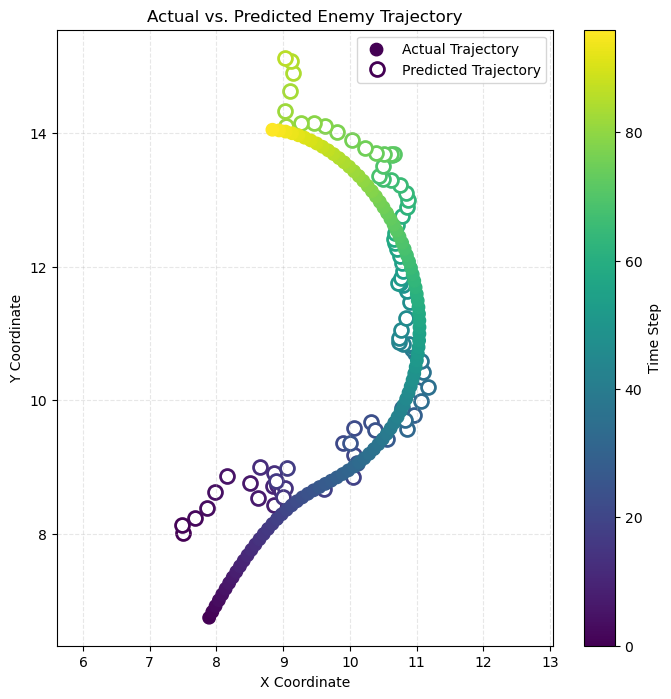

In [109]:
import matplotlib.pyplot as plt
import numpy as np

actual_trajectory = sample_enemy
predicted_trajectory = sample_predictions

plt.figure(figsize=(8, 8))

# Create color normalization
time_steps = np.arange(len(actual_trajectory))
norm = plt.Normalize(time_steps.min(), time_steps.max())

# Plot actual trajectory (solid points)
scatter_actual = plt.scatter(actual_trajectory[:, 0], 
                            actual_trajectory[:, 1], 
                            c=time_steps,
                            cmap='viridis',
                            norm=norm,
                            s=80,  # Slightly smaller size
                            marker='o',
                            label='Actual Trajectory',
                            zorder=2)  # Put actual points on top

# Plot predicted trajectory (hollow circles)
for i, (x, y) in enumerate(predicted_trajectory):
    color = plt.cm.viridis(norm(i))
    plt.plot(x, y, 'o', 
            markerfacecolor='white',  # White fill
            markeredgecolor=color,    # Colored edge matching the colormap
            markeredgewidth=2,        # Thick edge
            markersize=10,           # Size of markers
            label='Predicted Trajectory' if i == 0 else "",
            zorder=1)                # Put predicted points behind actual

# Add colorbar
plt.colorbar(scatter_actual, label='Time Step')

# Set axis limits and labels

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs. Predicted Enemy Trajectory')
plt.legend()

# Ensure equal aspect ratio
plt.axis('equal')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()
